In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import bz2
import os
import random
from tqdm import trange
import matplotlib
from scipy.integrate import odeint
from scipy.ndimage import gaussian_filter1d

In [2]:
dir_f='/home/amin/Downloads/RKI_COVID19.csv'
age_classes=['A00-A04','A05-A14','A15-A34','A35-A59','A60-A79','A80+']
age_rate=[4./100., 9./100., 23./100., 35./100.,22./100.,7./100.]
sex_classes=['W','M']
sex_rate=[51./100.,49./100]

In [3]:
data_raw=pd.read_csv(dir_f)

In [4]:
data_raw

ObjectId  IdBundesland          Bundesland            Landkreis  \
0              1             1  Schleswig-Holstein              SK Kiel   
1              2             1  Schleswig-Holstein              SK Kiel   
2              3             1  Schleswig-Holstein              SK Kiel   
3              4             1  Schleswig-Holstein              SK Kiel   
4              5             1  Schleswig-Holstein              SK Kiel   
...          ...           ...                 ...                  ...   
698231    698232            16           Thüringen  LK Altenburger Land   
698232    698233            16           Thüringen  LK Altenburger Land   
698233    698234            16           Thüringen  LK Altenburger Land   
698234    698235            16           Thüringen  LK Altenburger Land   
698235    698236            16           Thüringen  LK Altenburger Land   

       Altersgruppe Geschlecht  AnzahlFall  AnzahlTodesfall  \
0           A15-A34          M           1                0   
1           A15-A34          M           1                0   
2           A15-A34          M           1                0   
3           A15-A34          M           1                0   
4           A15-A34          M           1                0   
...             ...        ...         ...              ...   
698231         A80+          W          10                0   
698232         A80+          W           5                0   
698233         A80+          W           4                0   
698234         A80+          W           7                0   
698235         A80+          W           4                0   

                 Meldedatum  IdLandkreis             Datenstand  NeuerFall  \
0       2020/05/11 00:00:00         1002  12.12.2020, 00:00 Uhr          0   
1       2020/05/30 00:00:00         1002  12.12.2020, 00:00 Uhr          0   
2       2020/06/26 00:00:00         1002  12.12.2020, 00:00 Uhr          0   
3       2020/06/30 00:00:00         1002  12.12.2020, 00:00 Uhr          0   
4       2020/07/01 00:00:00         1002  12.12.2020, 00:00 Uhr          0   
...                     ...          ...                    ...        ...   
698231  2020/12/08 00:00:00        16077  12.12.2020, 00:00 Uhr          0   
698232  2020/12/09 00:00:00        16077  12.12.2020, 00:00 Uhr          0   
698233  2020/12/10 00:00:00        16077  12.12.2020, 00:00 Uhr          0   
698234  2020/12/10 00:00:00        16077  12.12.2020, 00:00 Uhr          1   
698235  2020/12/10 00:00:00        16077  12.12.2020, 00:00 Uhr          0   

        NeuerTodesfall             Refdatum  NeuGenesen  AnzahlGenesen  \
0                   -9  2020/04/27 00:00:00           0              1   
1                   -9  2020/05/28 00:00:00           0              1   
2                   -9  2020/06/26 00:00:00           0              1   
3                   -9  2020/06/27 00:00:00           0              1   
4                   -9  2020/06/26 00:00:00           0              1   
...                ...                  ...         ...            ...   
698231              -9  2020/12/08 00:00:00          -9              0   
698232              -9  2020/12/09 00:00:00          -9              0   
698233              -9  2020/12/07 00:00:00          -9              0   
698234              -9  2020/12/10 00:00:00          -9              0   
698235              -9  2020/12/10 00:00:00          -9              0   

        IstErkrankungsbeginn      Altersgruppe2  
0                          1  Nicht übermittelt  
1                          1  Nicht übermittelt  
2                          0  Nicht übermittelt  
3                          1  Nicht übermittelt  
4                          1  Nicht übermittelt  
...                      ...                ...  
698231                     0  Nicht übermittelt  
698232                     0  Nicht übermittelt  
698233                     1  Nicht übermittelt  
698234                  

In [5]:
melde_dus=np.sort(np.unique(data_raw.Meldedatum.values))

In [6]:
def get_S_I_R(age_rate,sex_rate,melde_dus):
    w_s_recovery=14
    
    infected=[]
    recovered=[]

    infected_age=[]
    recovered_age=[]

    infected_sex=[]
    recovered_sex=[]


    for data_ind in melde_dus:
        data_patch=data_raw[data_raw.Meldedatum==data_ind]

        data_rec_01=data_patch[(data_patch.NeuGenesen==0) | (data_patch.NeuGenesen==1)]
        data_rec_1n1=data_patch[(data_patch.NeuGenesen==-1) | (data_patch.NeuGenesen==1)]
        recovered.append( np.sum( data_rec_01.AnzahlGenesen.values)-np.sum( data_rec_1n1.AnzahlGenesen.values)  )

        data_inf_01=data_patch[(data_patch.NeuerFall==0) | (data_patch.NeuerFall==1)]
        data_inf_1n1=data_patch[(data_patch.NeuerFall==-1) | (data_patch.NeuerFall==1)]
        infected.append(np.sum( data_inf_01.AnzahlFall.values)-np.sum( data_inf_1n1.AnzahlFall.values))

        infected_age_in=[]
        recovered_age_in=[]
        for ag_c in age_classes:
            data_patch_age=data_patch[data_patch.Altersgruppe==ag_c]
            data_rec_01=data_patch_age[(data_patch_age.NeuGenesen==0) | (data_patch_age.NeuGenesen==1) ]
            data_rec_1n1=data_patch_age[(data_patch_age.NeuGenesen==-1) | (data_patch_age.NeuGenesen==1) ]

            data_inf_01=data_patch_age[(data_patch_age.NeuerFall==0) | (data_patch_age.NeuerFall==1) ]
            data_inf_1n1=data_patch_age[(data_patch_age.NeuerFall==-1) | (data_patch_age.NeuerFall==1) ]

            recovered_age_in.append( np.sum( data_rec_01.AnzahlGenesen.values)-np.sum( data_rec_1n1.AnzahlGenesen.values)  )
            infected_age_in.append( np.sum( data_inf_01.AnzahlFall.values)-np.sum( data_inf_1n1.AnzahlFall.values)  )

        infected_age.append(infected_age_in)
        recovered_age.append(recovered_age_in)


        infected_sex_in=[]
        recovered_sex_in=[]
        for ag_c in sex_classes:
            data_patch_sex=data_patch[data_patch.Geschlecht==ag_c]
            data_rec_01=data_patch_sex[(data_patch_sex.NeuGenesen==0) | (data_patch_sex.NeuGenesen==1) ]
            data_rec_1n1=data_patch_sex[(data_patch_sex.NeuGenesen==-1) | (data_patch_sex.NeuGenesen==1) ]

            data_inf_01=data_patch_sex[(data_patch_sex.NeuerFall==0) | (data_patch_sex.NeuerFall==1) ]
            data_inf_1n1=data_patch_sex[(data_patch_sex.NeuerFall==-1) | (data_patch_sex.NeuerFall==1) ]

            recovered_sex_in.append( np.sum( data_rec_01.AnzahlGenesen.values)-np.sum( data_rec_1n1.AnzahlGenesen.values)  )
            infected_sex_in.append( np.sum( data_inf_01.AnzahlFall.values)-np.sum( data_inf_1n1.AnzahlFall.values)  )

        infected_sex.append(infected_sex_in)
        recovered_sex.append(recovered_sex_in)
        
        
    melde_dus=[melde_dus_in.split(' ')[0] for melde_dus_in in melde_dus]
    melde_dus=np.array(melde_dus[30:len(melde_dus)-27])
    
    infected_age=np.array(infected_age)
    recovered_age=np.array(recovered_age)
    
    infected_sex=np.array(infected_sex)
    recovered_sex=np.array(recovered_sex)
    
    infected=np.array(infected[30:len(infected)-27])
    recovered=np.array(recovered[30:len(recovered)-27])
    
    infected_age=infected_age[30:infected_age.shape[0]-27,:]
    recovered_age=recovered_age[30:recovered_age.shape[0]-27,:]
    
    
    infected_sex=infected_sex[30:infected_sex.shape[0]-27,:]
    recovered_sex=recovered_sex[30:recovered_sex.shape[0]-27,:]
    
    

    
    I_new=np.zeros(len(infected)-w_s_recovery+1)
    I_age_new=np.zeros((len(infected)-w_s_recovery+1, infected_age.shape[1]))
    I_sex_new=np.zeros((len(infected)-w_s_recovery+1, infected_sex.shape[1]))
    for i in range(len(infected)-w_s_recovery+1):
        
        i_start=i-w_s_recovery
        if i_start<0:
            i_start=0

        I_new[i]= np.sum(infected[i_start:i])
        
        for j in range(infected_age.shape[1]):
            I_age_new[i,j]=np.sum(infected_age[i_start:i,j])
        for l in range(infected_sex.shape[1]):
            I_sex_new[i,l]=np.sum(infected_sex[i_start:i,l])
        
        
    R_new=np.zeros(len(infected)-w_s_recovery+1)
    R_age_new=np.zeros((len(infected)-w_s_recovery+1, infected_age.shape[1]))
    R_sex_new=np.zeros((len(infected)-w_s_recovery+1, infected_sex.shape[1]))
    
    for i in range(w_s_recovery,len(infected)-w_s_recovery+1):
        R_new[i]=np.sum(recovered[:i-w_s_recovery])
        for j in range(infected_age.shape[1]):
            R_age_new[i,j]=np.sum(recovered_age[:i-w_s_recovery,j])
        for l in range(infected_sex.shape[1]):
            R_sex_new[i,l]=np.sum(recovered_sex[:i-w_s_recovery,l])
            
    
        
    S=80000000-(I_new+R_new)
    S_age=80000000*np.array(age_rate)-(I_age_new+R_age_new)
    S_sex=80000000*np.array(sex_rate)-(I_sex_new+R_sex_new)
    
    
    
    
        
    

    
    return S,I_new,R_new, S_age,I_age_new,R_age_new,S_sex,I_sex_new,R_sex_new


In [7]:
S,I,R, S_age,I_age,R_age,S_sex,I_sex,R_sex=get_S_I_R(age_rate,sex_rate,melde_dus)

In [8]:
melde_dus=[melde_dus_in.split(' ')[0] for melde_dus_in in melde_dus]

In [9]:
melde_dus=melde_dus[30:len(melde_dus)-27]

In [10]:
def smooth_all_time_series(S,I,R, S_age,I_age,R_age,S_sex,I_sex,R_sex):
    S=gaussian_filter1d(S,3)
    I=gaussian_filter1d(I,3)
    R=gaussian_filter1d(R,3)
    
    for i in range(S_age.shape[1]):
        S_age[:,i]=gaussian_filter1d(S_age[:,i],3)
        I_age[:,i]=gaussian_filter1d(I_age[:,i],3)
        R_age[:,i]=gaussian_filter1d(R_age[:,i],3)
        
    for i in range(S_sex.shape[1]):
        S_sex[:,i]=gaussian_filter1d(S_sex[:,i],3)
        I_sex[:,i]=gaussian_filter1d(I_sex[:,i],3)
        R_sex[:,i]=gaussian_filter1d(R_sex[:,i],3)
    return S,I,R, S_age,I_age,R_age,S_sex,I_sex,R_sex
        
    

In [11]:
#S,I,R, S_age,I_age,R_age,S_sex,I_sex,R_sex=smooth_all_time_series(S,I,R, S_age,I_age,R_age,S_sex,I_sex,R_sex)

In [12]:
def get_next_points(S_h,I_h,R_h,beta,gamma,N):
    deltat=1
    s_k1=-beta*deltat/float(N)*np.array(S_h[:])*np.array(I_h[:])+np.array(S_h[:])
    i_k1=beta*deltat/float(N)-gamma*deltat*np.array(I_h[:])+np.array(I_h[:])
    r_k1=gamma*deltat*np.array(I_h[:])+np.array(R_h[:])
    return s_k1,i_k1,r_k1
    

In [13]:
def calc_arg(S,I,R,beta,gamma,N,param):
    
    s_p,i_p,r_p=get_next_points(S,I,R,beta,gamma,N)
    if param=='gamma':
        return -np.dot(r_p[:len(r_p)-1]-R[1:]  , r_p[:len(r_p)-1]-R[1:]  )
    elif param=='beta':
        return -np.dot(s_p[:len(s_p)-1]-S[1:]  , s_p[:len(s_p)-1]-S[1:]  )

In [14]:
def sampling(S,I,R,N,sigma,param='beta'):
    S=np.array(S)
    I=np.array(I)
    R=np.array(R)
    x1=np.random.random()
    
    if param=='gamma':
        arg=calc_arg(S,I,R,0.1,x1,N,param)
    elif param=='beta':
        arg=calc_arg(S,I,R,x1,0.1,N,param)
    
    x_res=[]

    realization=15000
    sigma_random_walk=1e-2
    
    
    for i in range(realization):
        x1_new=x1+sigma_random_walk*(np.random.random()-0.5)
        
        
        if param=='gamma':
            #sigma=1e4
            argnew=calc_arg(S,I,R,0.1,x1_new,N,param)
        elif param=='beta':
            #sigma=1e4
            argnew=calc_arg(S,I,R,x1_new,0.1,N,param)
        

        dn=min(1,np.exp( (argnew-arg)/float(sigma)))
        
        dran=random.random()
        
        if dn>dran:
            x1=x1_new
            arg=argnew
            x_res.append(x1)
        
    return x_res

In [15]:
def get_gamma_and_beta_by_time_sampling(S,I,R,N,sigma):
    
    window_size=30
    iterartion=len(S)-window_size

    gamma_all=[]
    beta_all=[]
    
    gamma_all_std=[]
    beta_all_std=[]
    for l1 in range(iterartion-1):
        S_p=S[l1:l1+window_size]
        I_p=I[l1:l1+window_size]
        R_p=R[l1:l1+window_size]

        res_gamma=sampling(S_p,I_p,R_p,N,sigma,'gamma')
        res_beta=sampling(S_p,I_p,R_p,N,sigma,'beta')


        gamma_all.append(np.mean(res_gamma[300:]))
        beta_all.append(np.mean(res_beta[300:]))
        
        gamma_all_std.append(np.std(res_gamma[300:]))
        beta_all_std.append(np.std(res_beta[300:]))
    return beta_all,gamma_all,beta_all_std,gamma_all_std

In [16]:
def get_gamma_and_beta_by_time(S,I,R):
    
    window_size=30
    iterartion=len(S)-window_size

    gamma_all=[]
    beta_all=[]
    for l1 in range(iterartion-1):
        S_p=S[l1:l1+window_size]
        I_p=I[l1:l1+window_size]
        R_p=R[l1:l1+window_size]


        en=len(S_p);
        st=0;
        y=np.log(I_p)
        t=np.array(range(st,en))

        m,b=np.polyfit(t,y,1)

        g=[]
        for i in range(st,en-1):
            oo=(R_p[i+1]-R_p[i])/I_p[i]
            g.append(oo)


        gamma=np.mean(g)
        beta=m+gamma

        gamma_all.append(gamma)
        beta_all.append(beta)
    return beta_all,gamma_all

In [17]:
N=80000000
sigma=1e4
beta_all,gamma_all,beta_all_std,gamma_all_std=get_gamma_and_beta_by_time_sampling(S,I,R,N,sigma)

/home/amin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


In [18]:
beta_ages_method2=[]
gamma_ages_method2=[]


for i in range(S_age.shape[1]):
    beta_age_in,gamma_age_in=get_gamma_and_beta_by_time(S_age[:,i],I_age[:,i],R_age[:,i])
    
    beta_ages_method2.append(beta_age_in)
    gamma_ages_method2.append(gamma_age_in)


/home/amin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/amin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [19]:
beta_ages=[]
gamma_ages=[]
beta_ages_std=[]
gamma_ages_std=[]
sigma=1e2
N_ages=80000000*np.array(age_rate)
for i in range(S_age.shape[1]):
    beta_age_in,gamma_age_in,beta_age_std_in,gamma_age_std_in=get_gamma_and_beta_by_time_sampling(S_age[:,i],I_age[:,i],R_age[:,i],N_ages[i],sigma)
    
    beta_ages.append(beta_age_in)
    gamma_ages.append(gamma_age_in)
    beta_ages_std.append(beta_age_std_in)
    gamma_ages_std.append(gamma_age_std_in)
    

/home/amin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
/home/amin/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/amin/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/amin/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/amin/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/amin/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
beta_sex=[]
gamma_sex=[]
beta_sex_std=[]
gamma_sex_std=[]
sigma=1e3

N_sexes=80000000*np.array(sex_rate)
for i in range(S_sex.shape[1]):
    beta_age_in,gamma_age_in,beta_age_std_in,gamma_age_std_in=get_gamma_and_beta_by_time_sampling(S_sex[:,i],I_sex[:,i],R_sex[:,i],N_sexes[i],sigma)
    
    beta_sex.append(beta_age_in)
    gamma_sex.append(gamma_age_in)
    beta_sex_std.append(beta_age_std_in)
    gamma_sex_std.append(gamma_age_std_in)

/home/amin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


In [21]:
dates=np.copy(melde_dus)
for jj in range(len(melde_dus)):
    if jj%5>0:
        dates[jj]=''
        

In [22]:
R0=(np.array(beta_all))/(np.array(gamma_all))
R0_ages=(np.array(beta_ages))/(np.array(gamma_ages))
R0_sex=(np.array(beta_sex))/(np.array(gamma_sex))

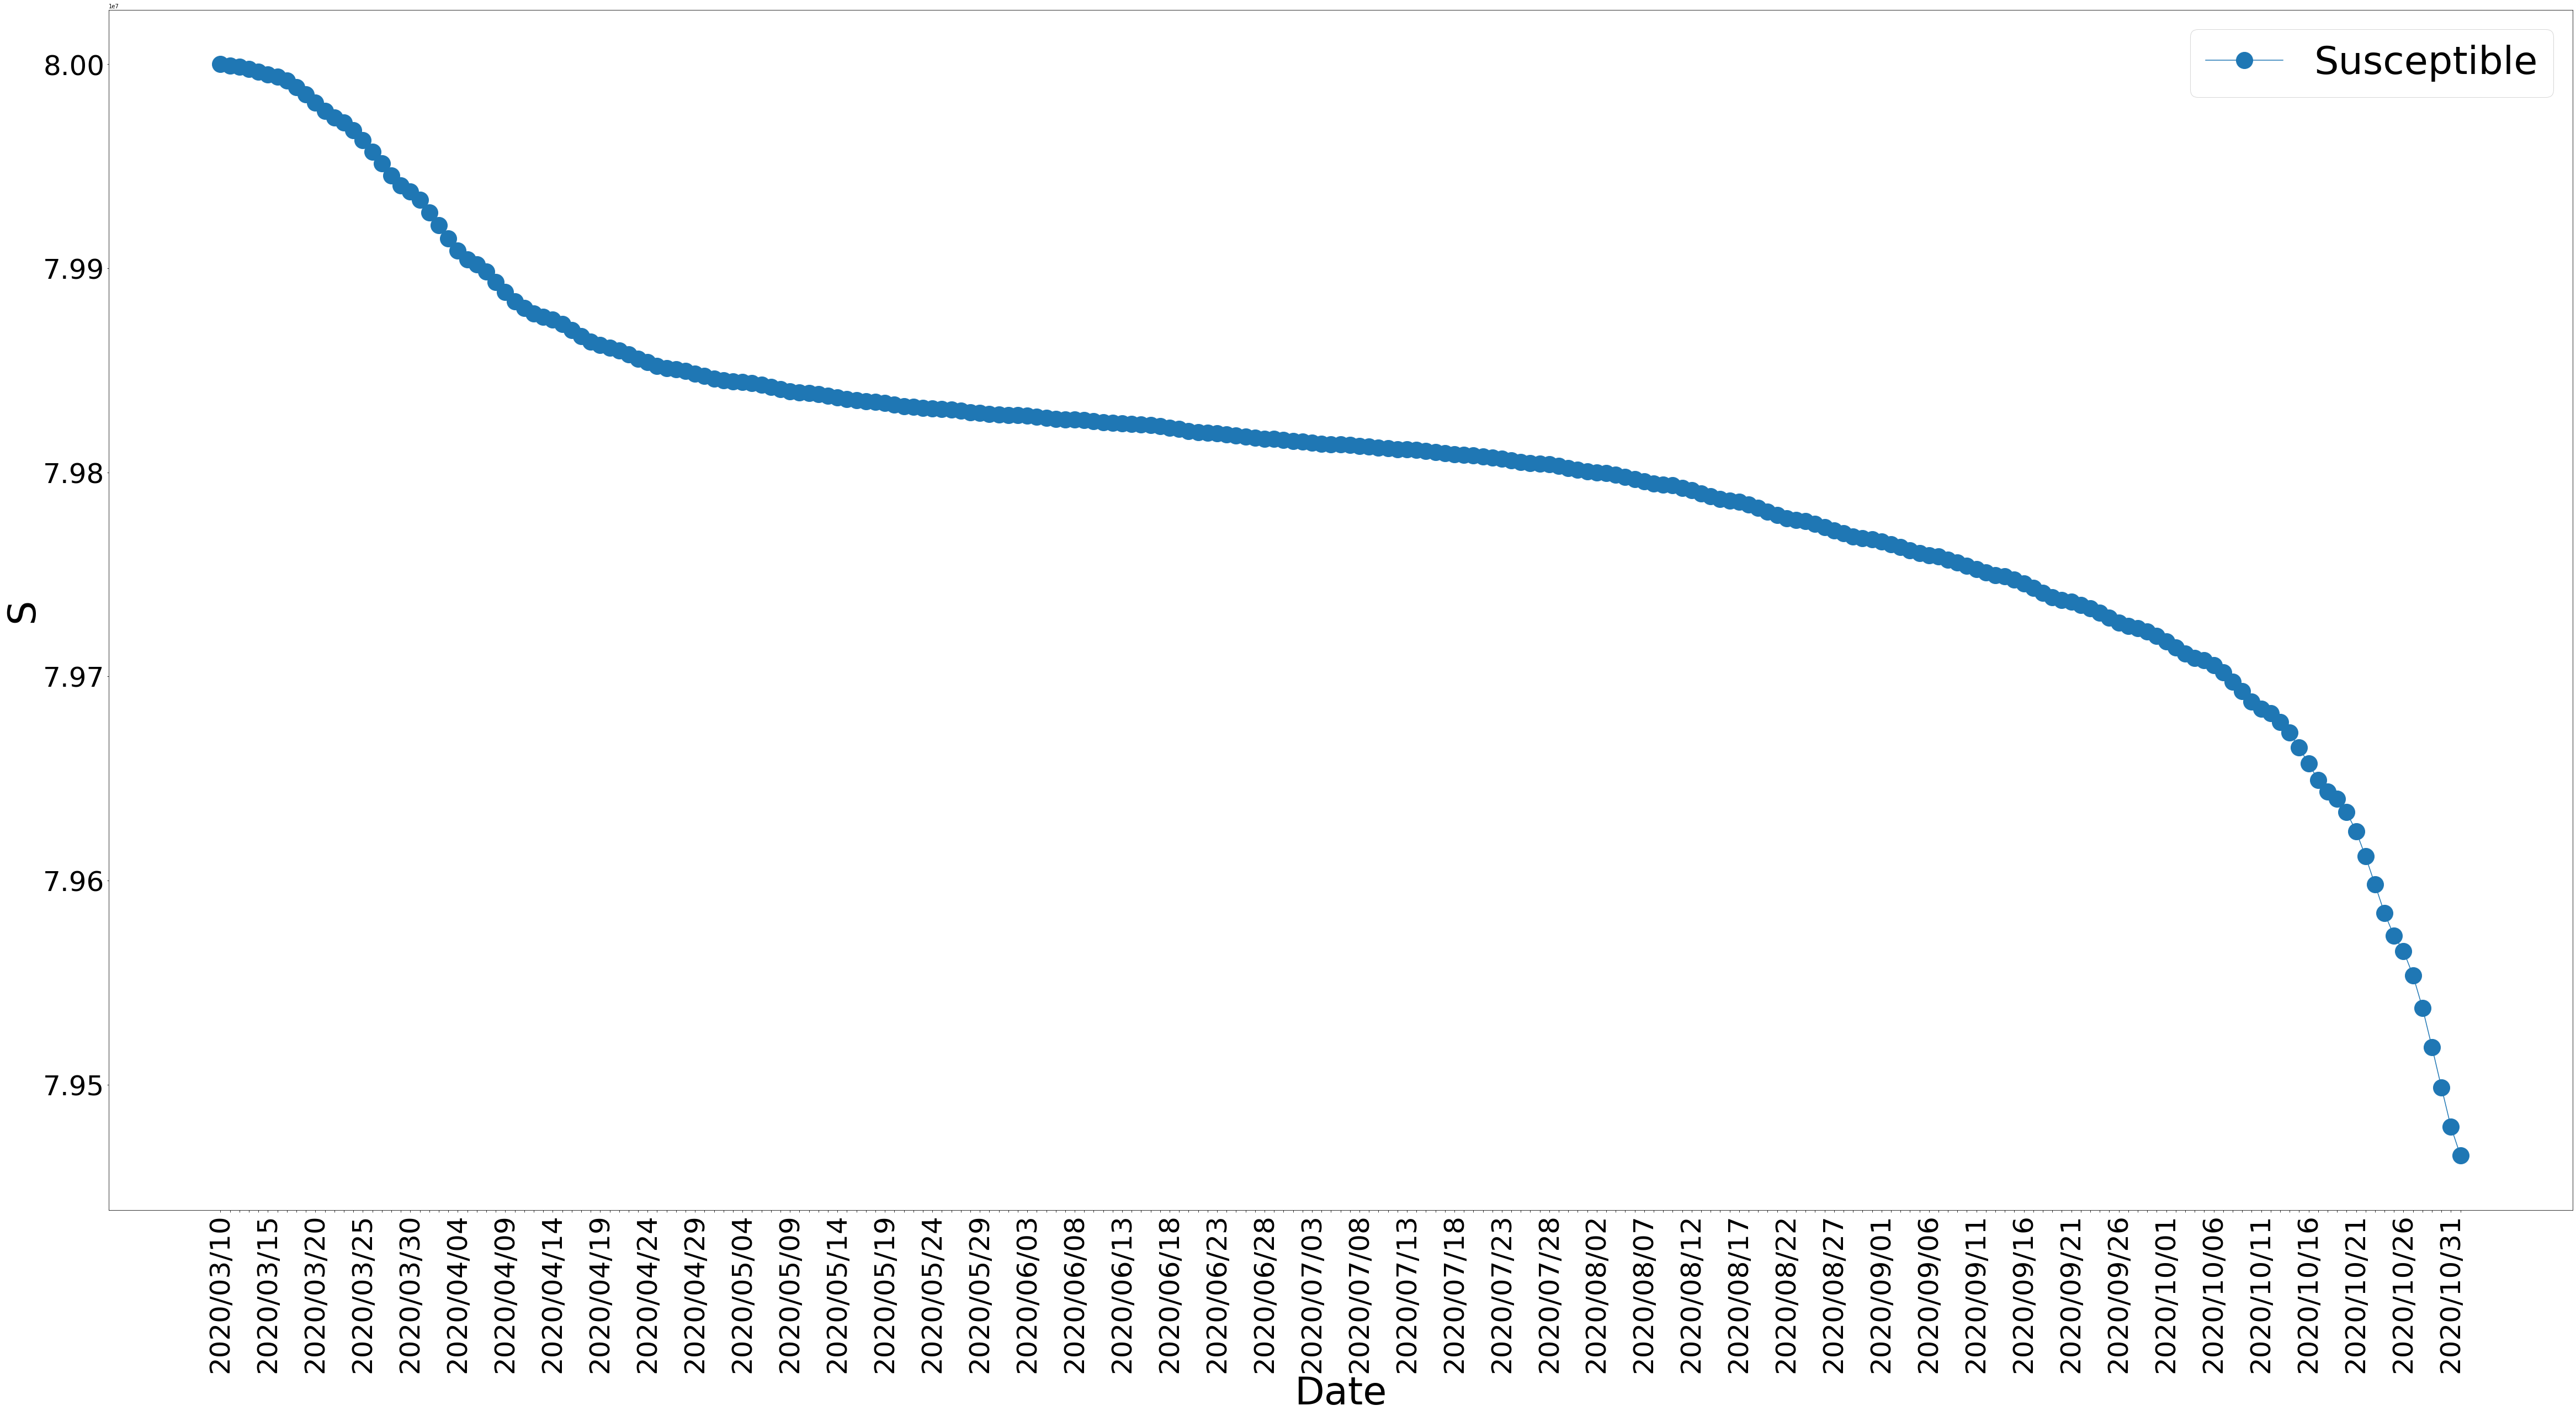

In [23]:
plt.figure(figsize=(80,40))
plt.plot(S,'-o',markersize=30,label='Susceptible')
plt.xticks(np.arange(len(dates[:len(S)])), dates[:len(S)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('S',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

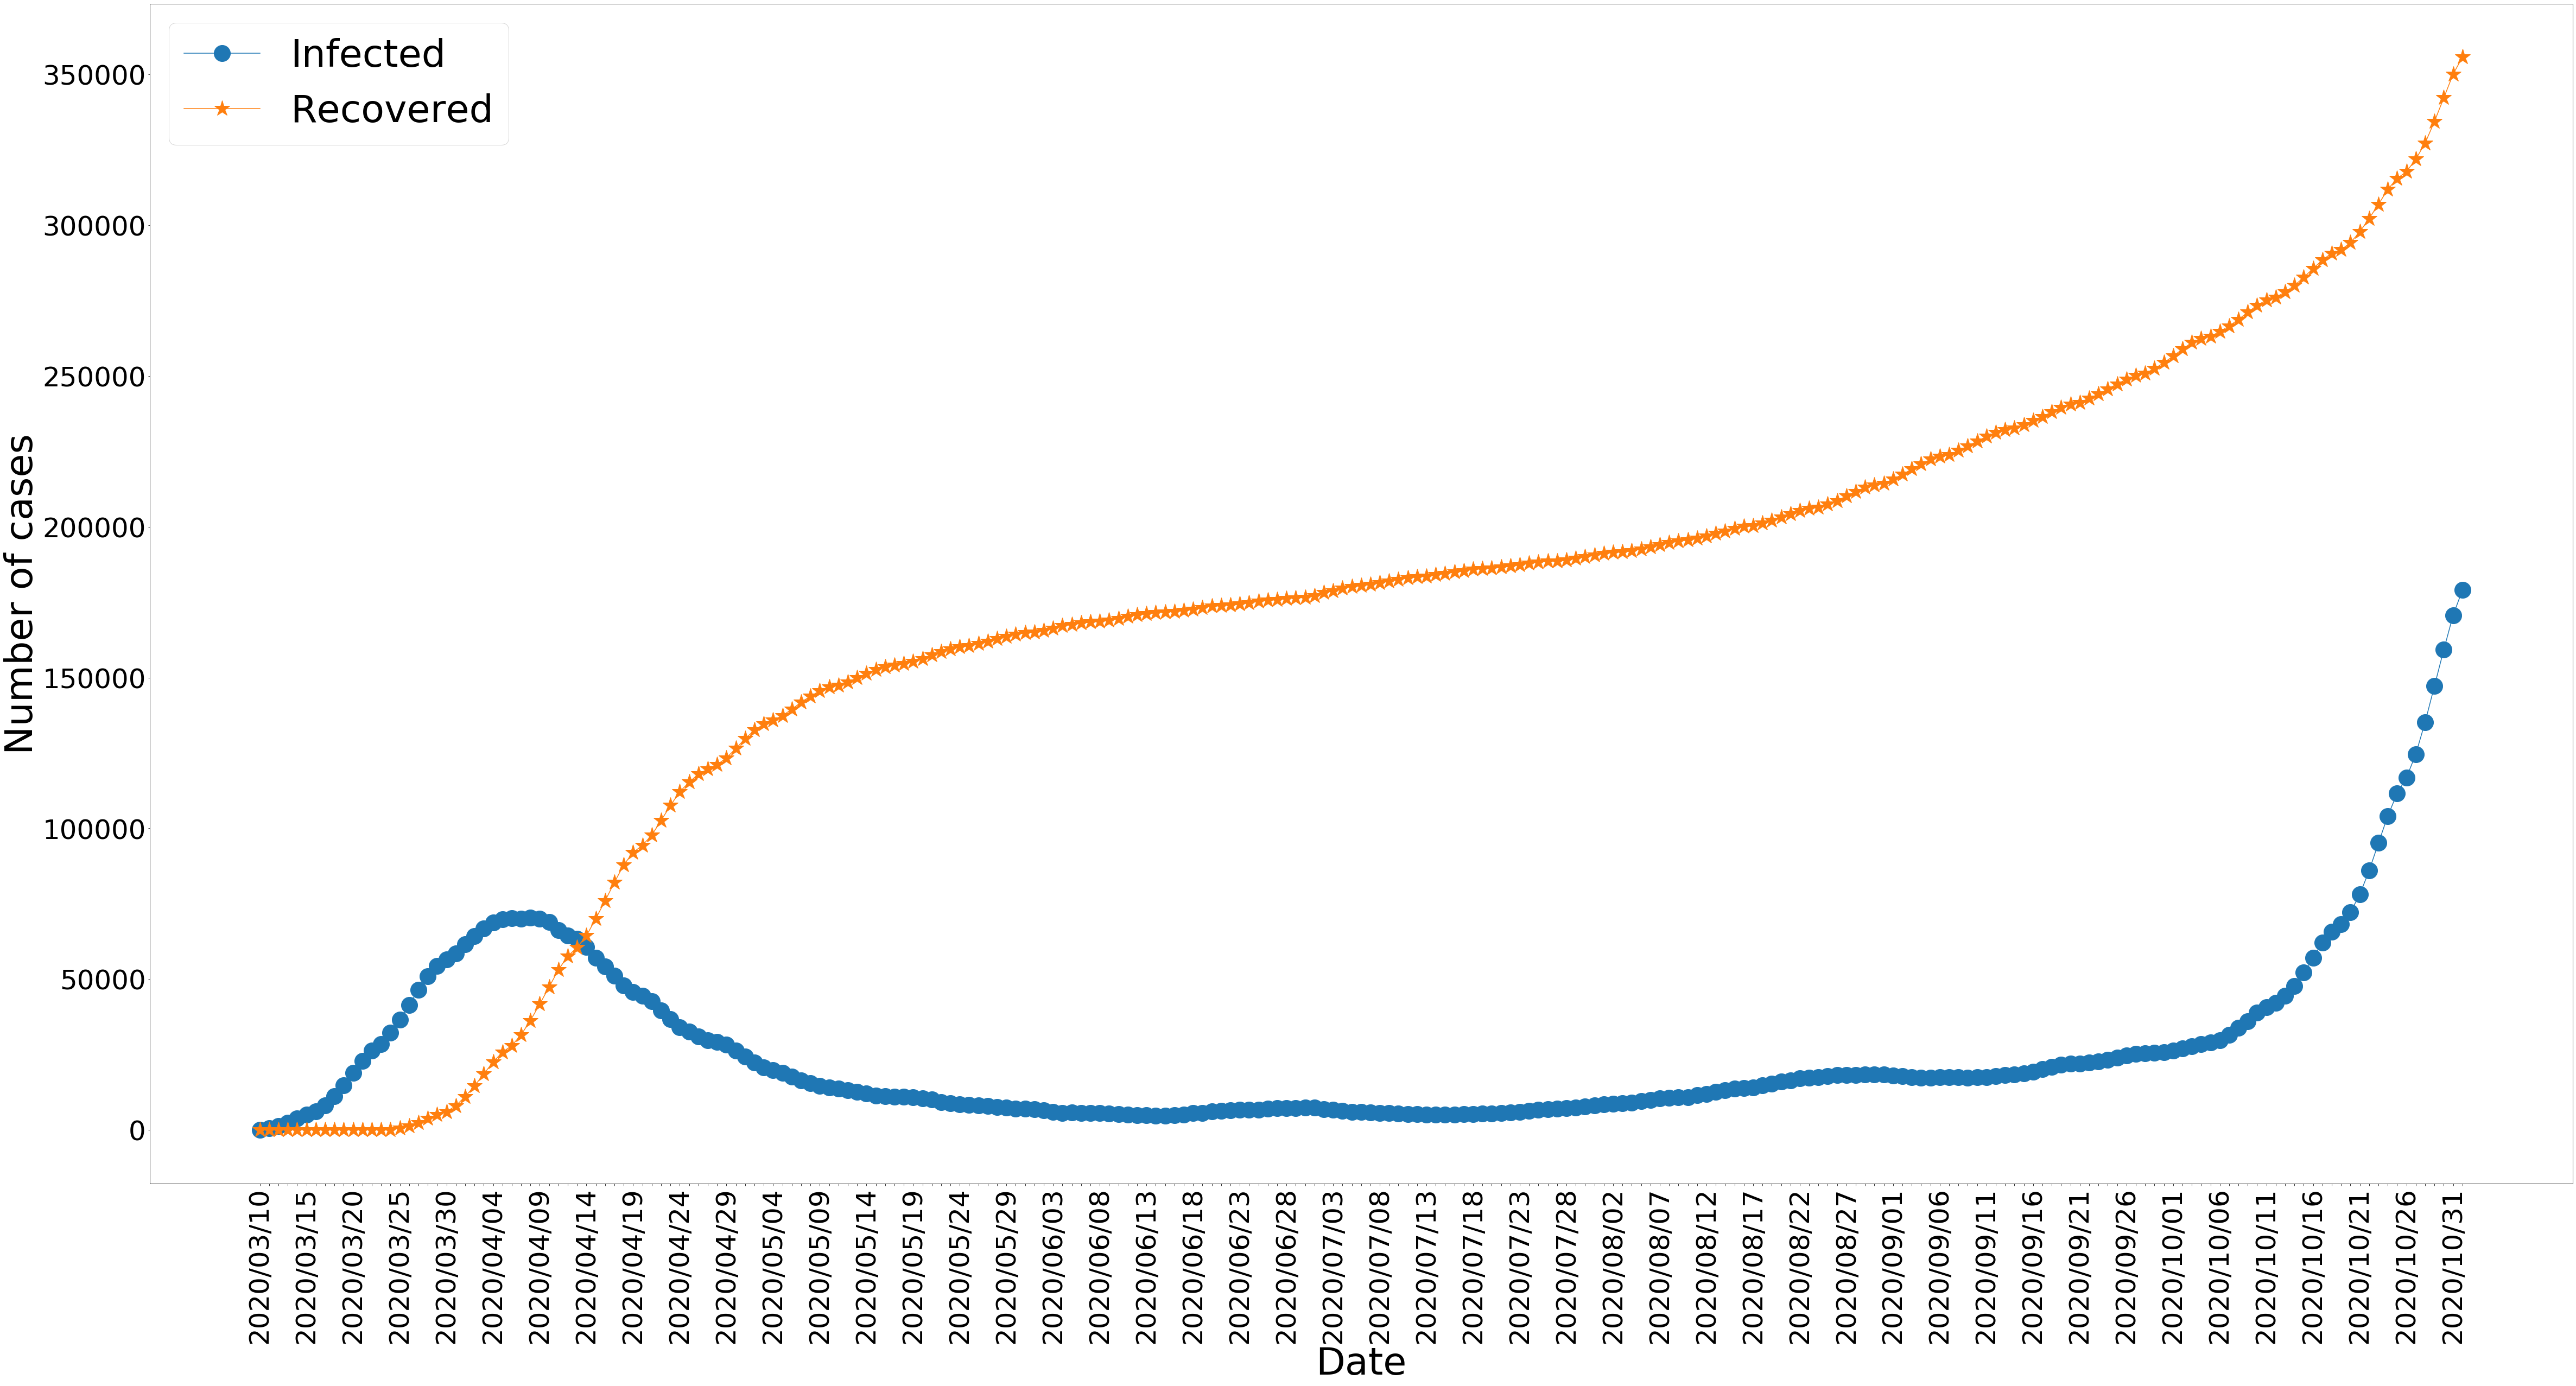

In [24]:
plt.figure(figsize=(80,40))
plt.plot(I,'-o',markersize=30,label='Infected')
plt.plot(R,'-*',markersize=30,label='Recovered')
plt.xticks(np.arange(len(dates[:len(S)])), dates[:len(S)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('Number of cases',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

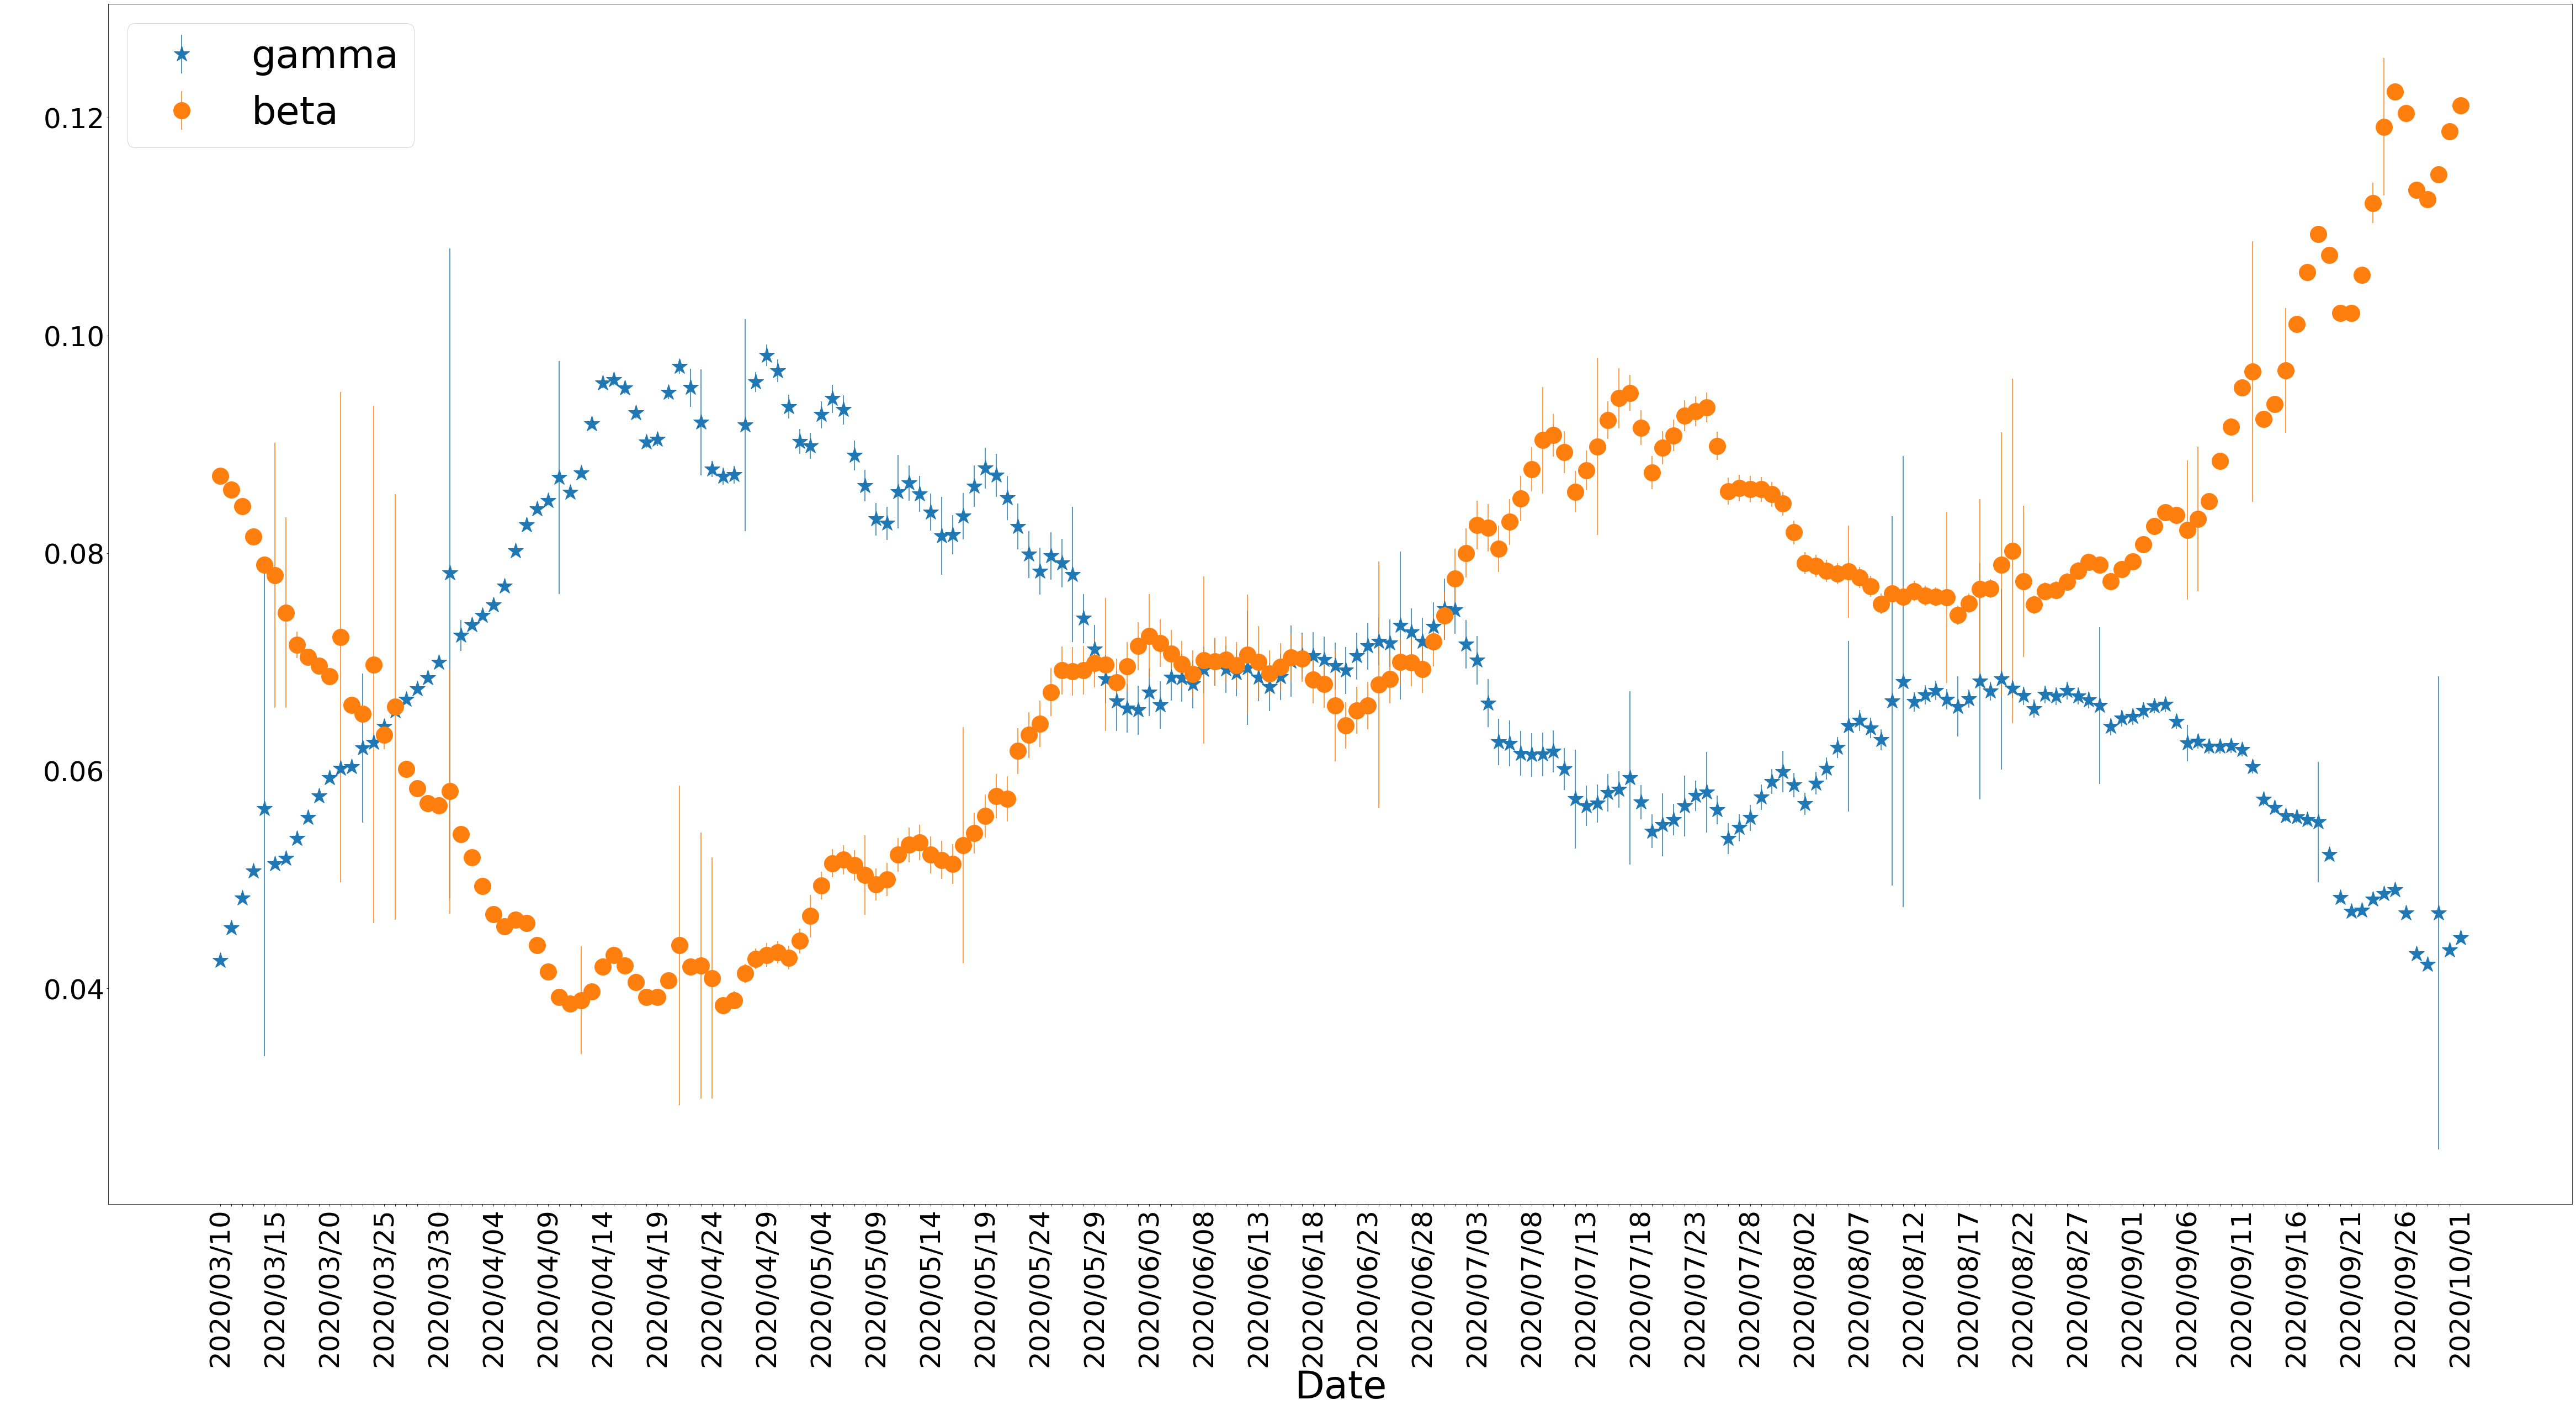

In [25]:
plt.figure(figsize=(80,40))
plt.errorbar(np.array(range(len(gamma_all))),np.array(gamma_all), np.array(gamma_all_std), linestyle='None', marker='*',markersize=30,label='gamma')
plt.errorbar(np.array(range(len(beta_all))),np.array(beta_all), np.array(beta_all_std), linestyle='None', marker='o',markersize=30,label='beta')
plt.xticks(np.arange(len(dates[:len(beta_all)])), dates[:len(beta_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel(' ',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

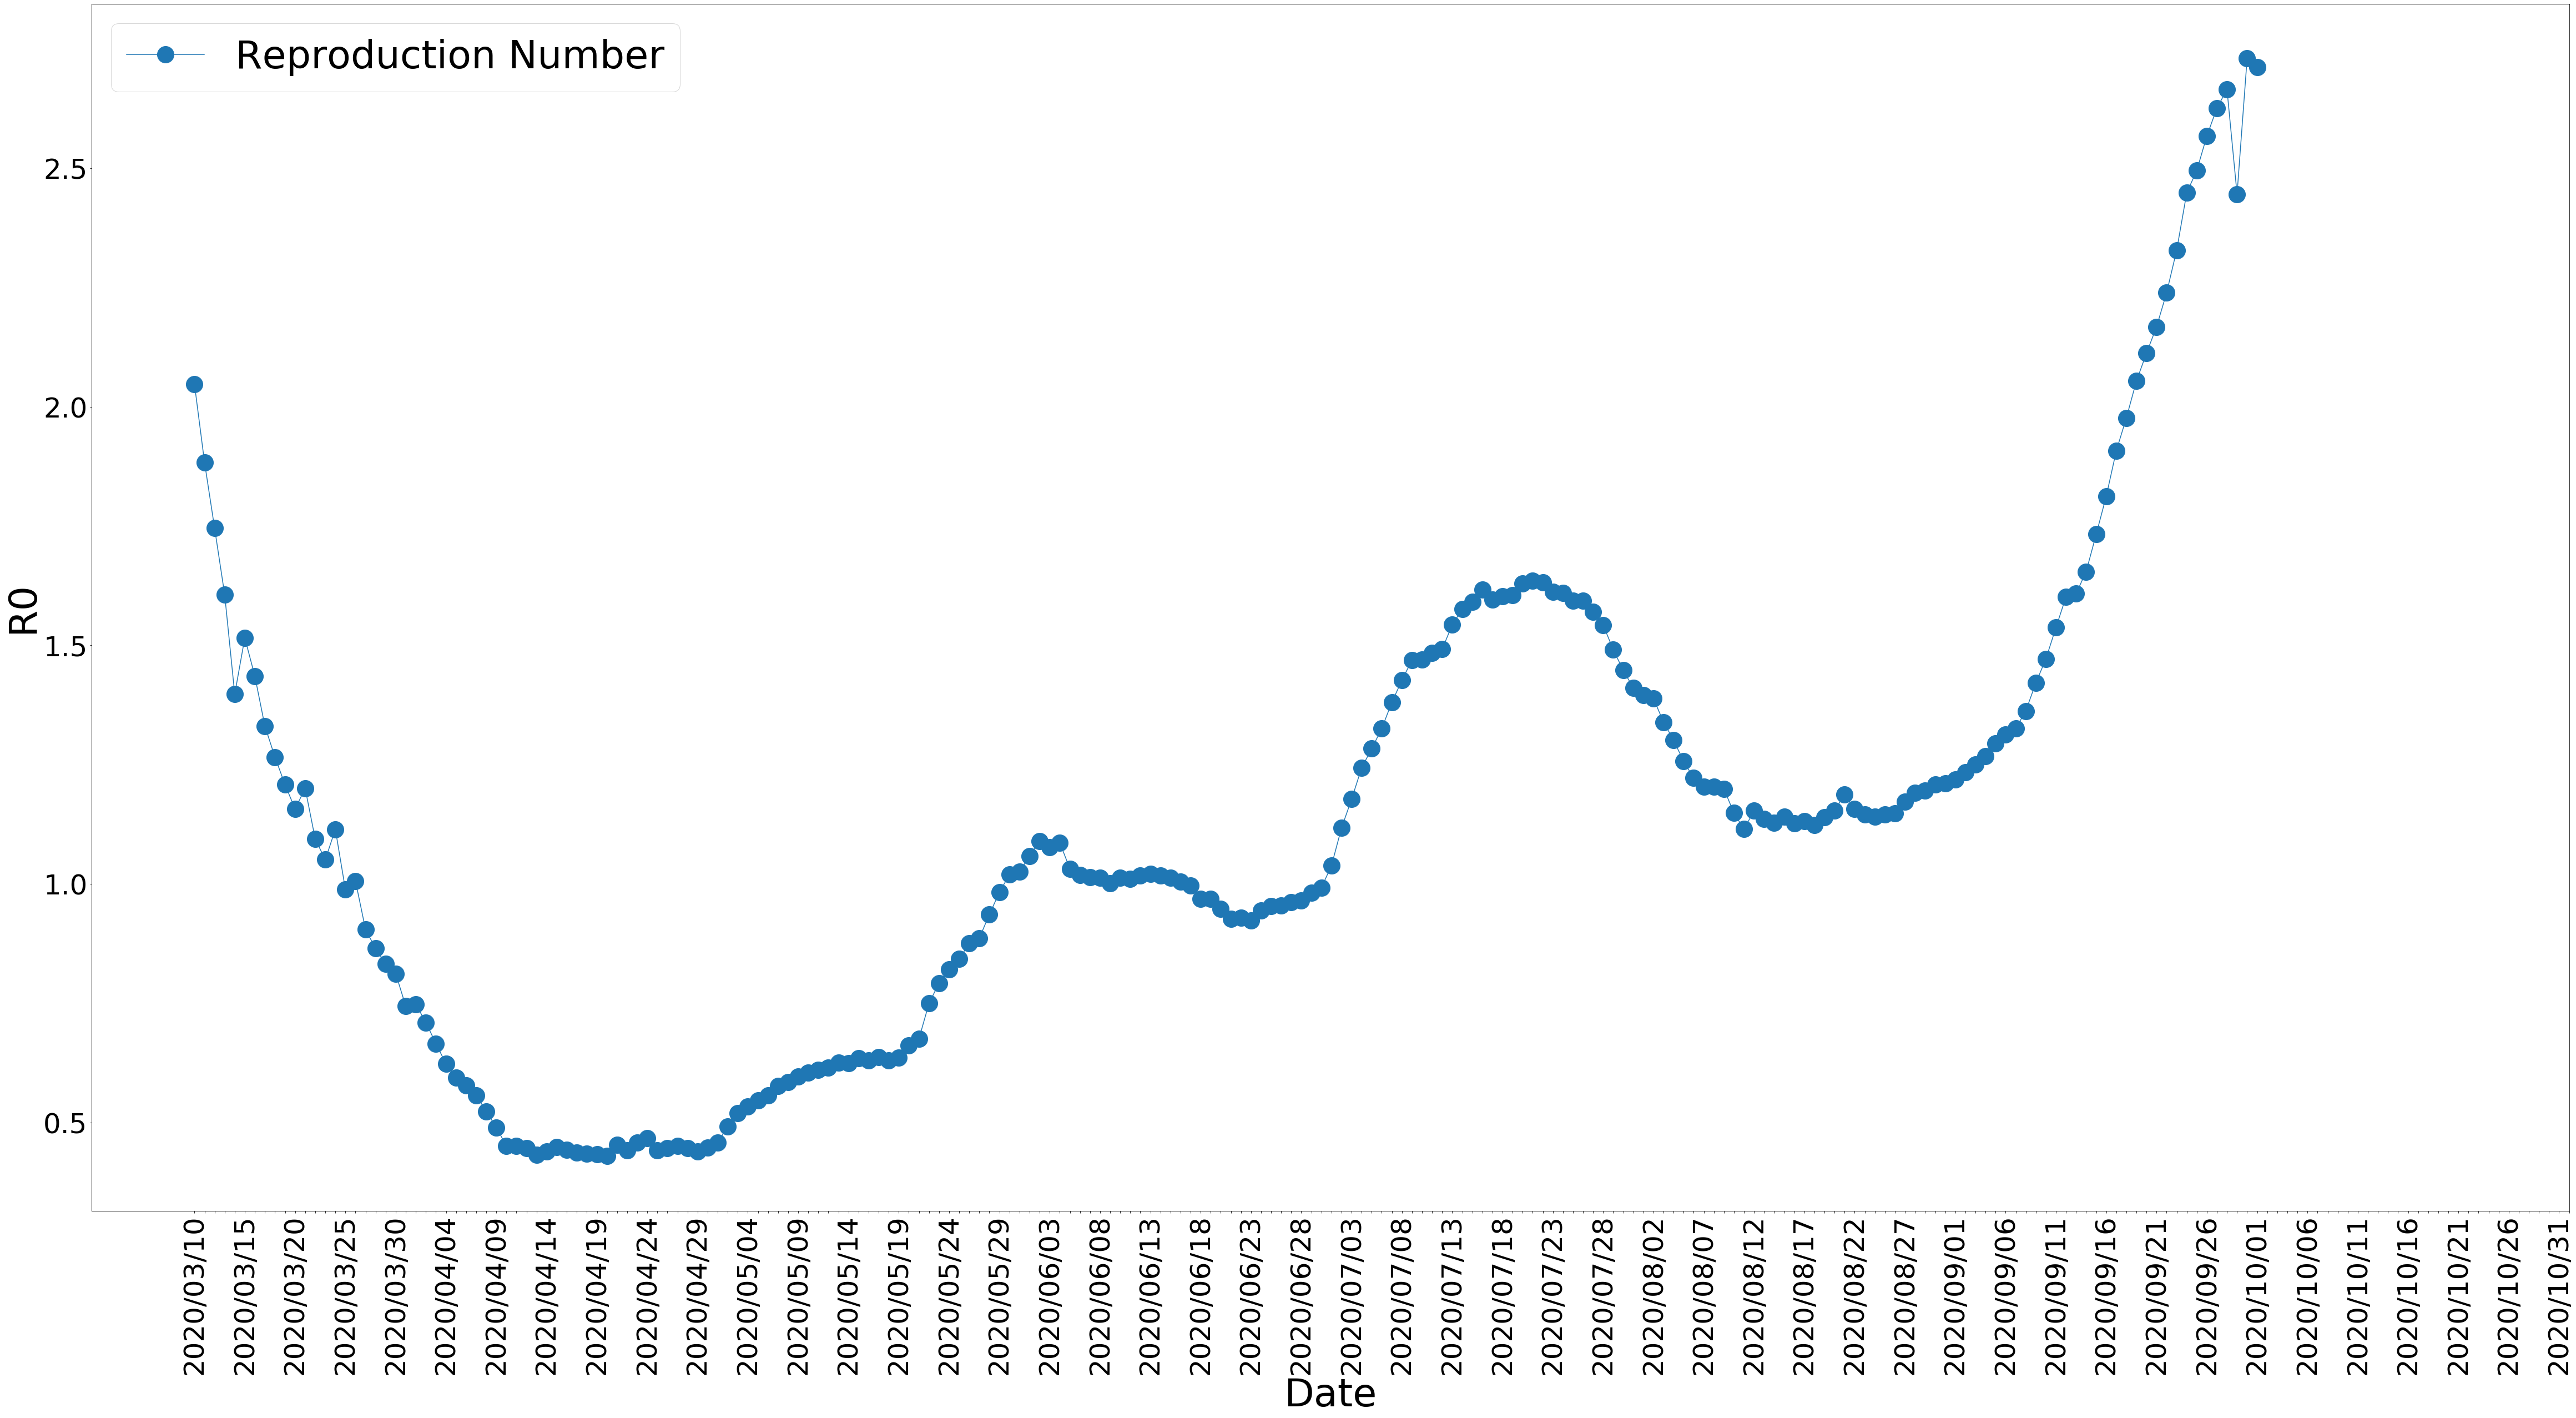

In [26]:
plt.figure(figsize=(80,40))
plt.plot(R0,'-o',markersize=30,label='Reproduction Number')
plt.xticks(np.arange(len(dates[:len(S)])), dates[:len(S)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('R0',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

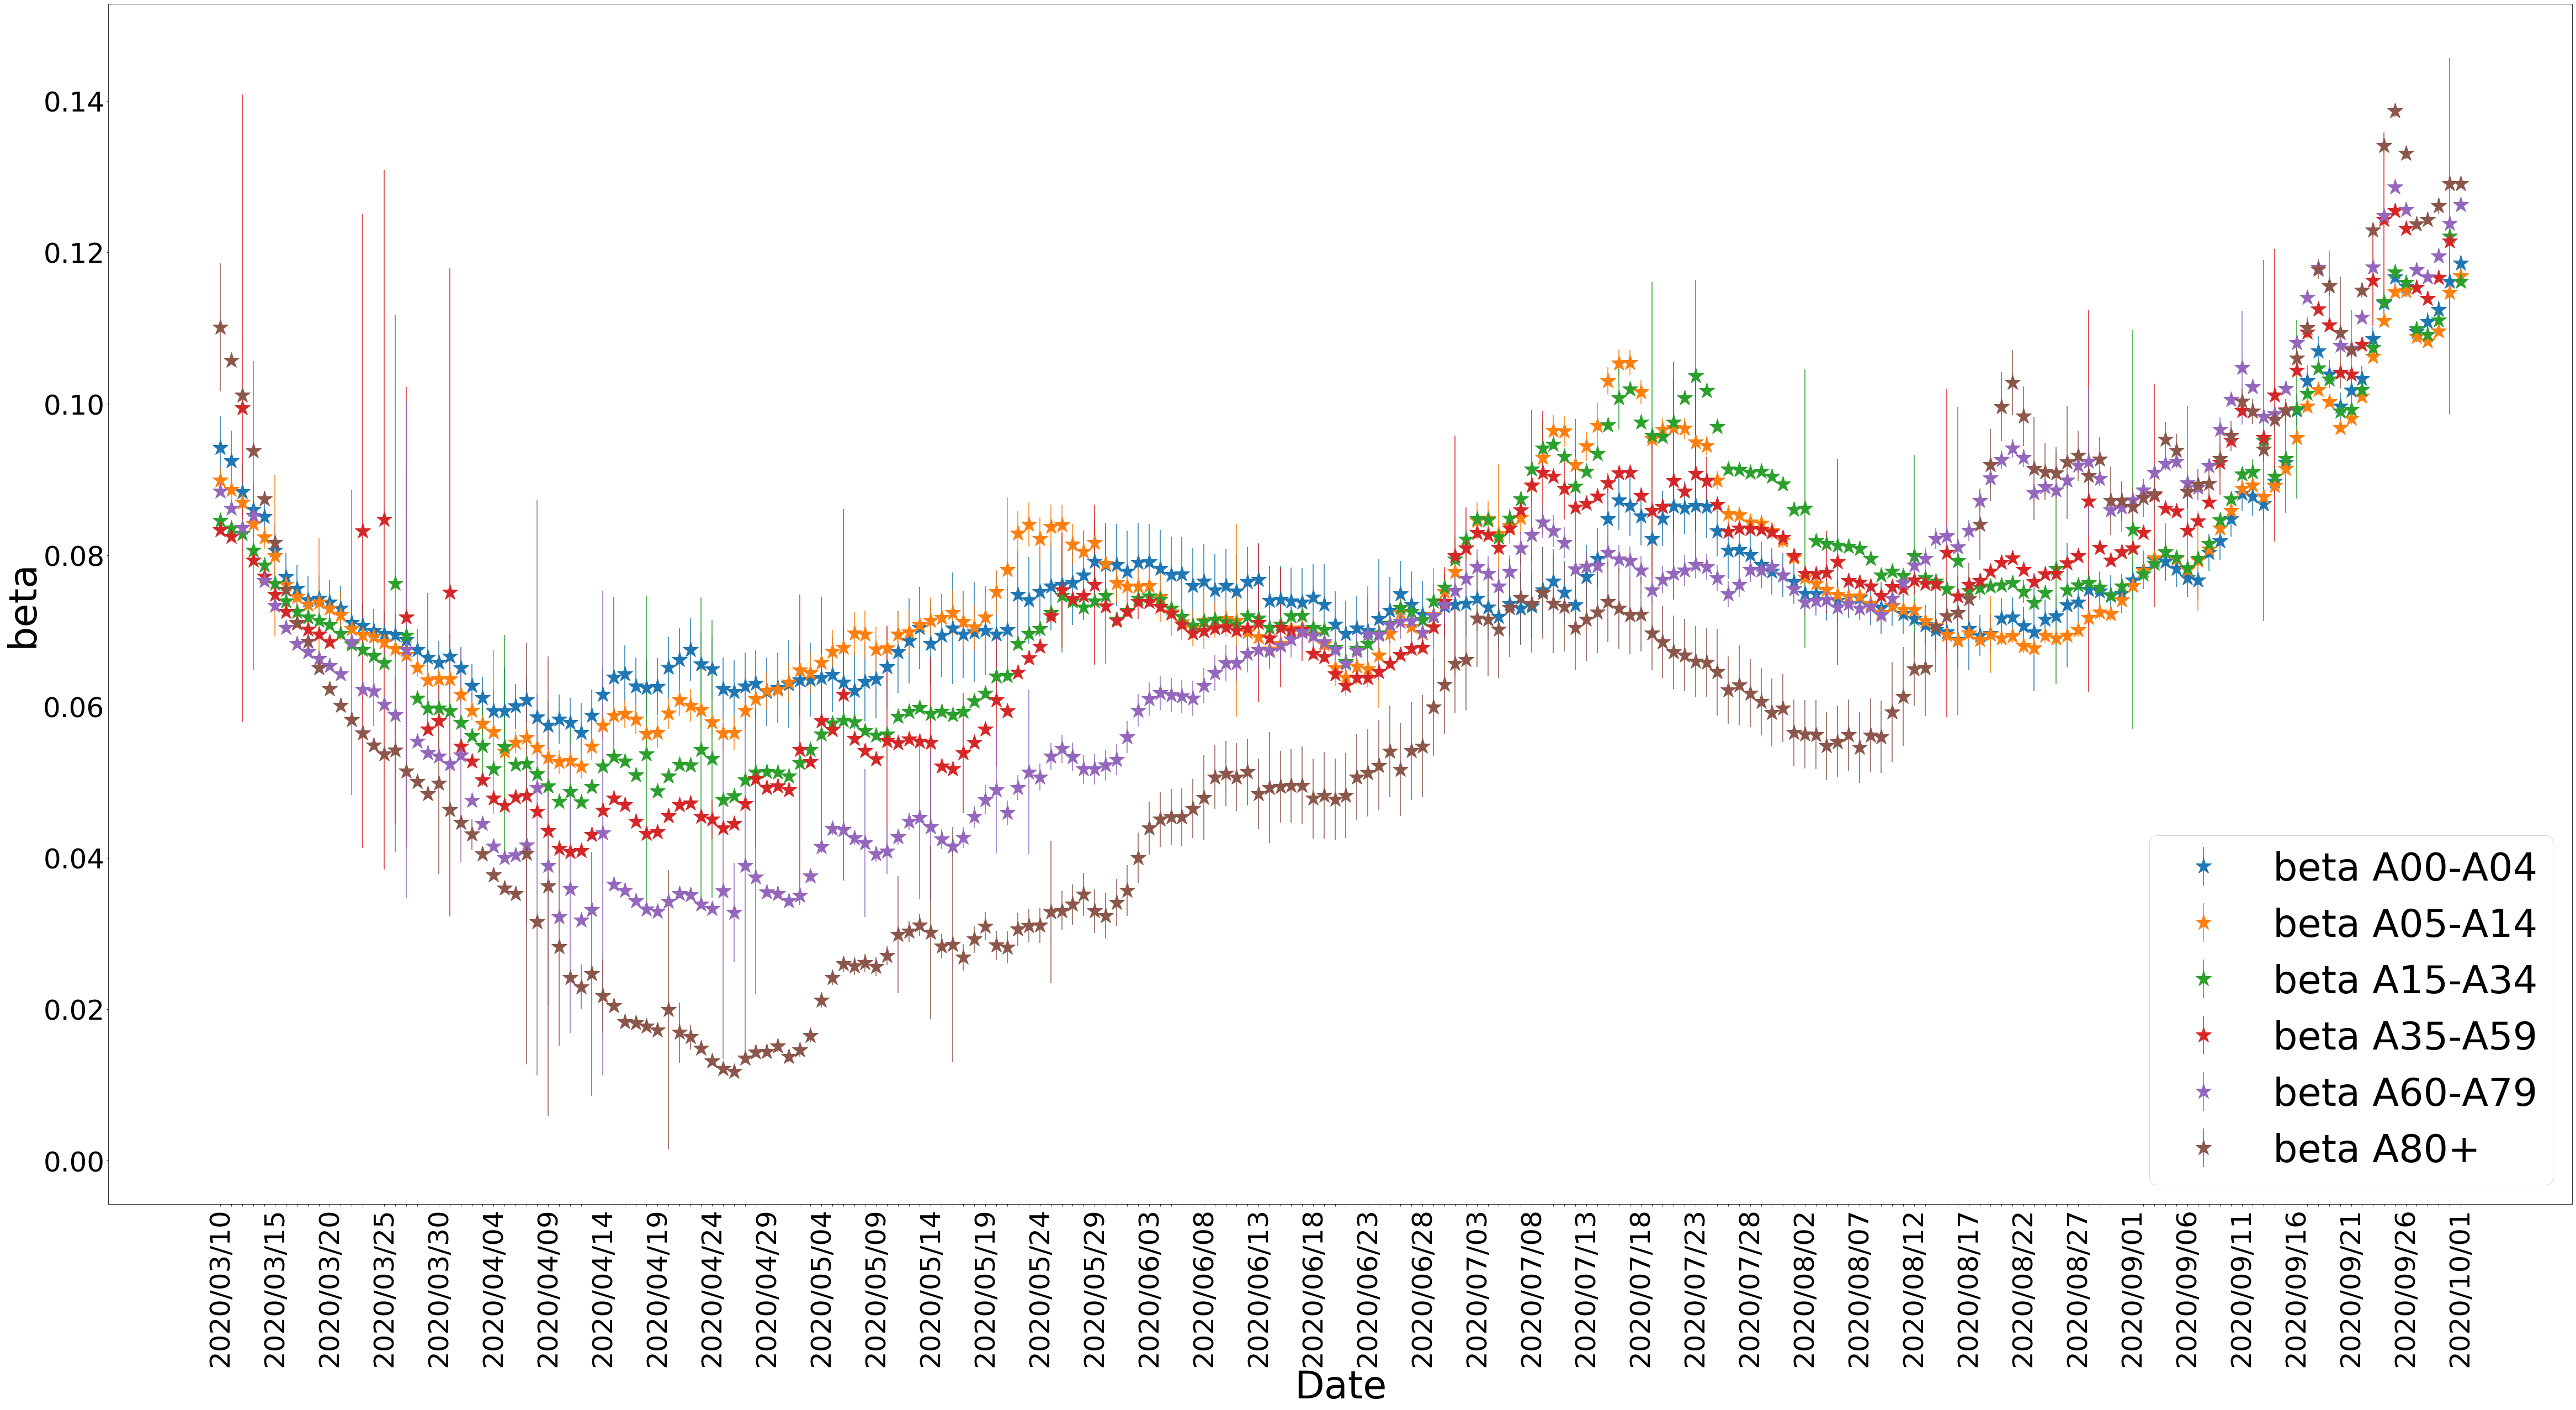

In [27]:

plt.figure(figsize=(80,40))
for i in range(len(beta_ages_method2)):
    plt.errorbar(np.array(range(len(beta_ages_method2[i]))),beta_ages[i],beta_ages_std[i],linestyle='None',  marker='*',markersize=30,label='beta '+age_classes[i])

plt.xticks(np.arange(len(dates[:len(beta_all)])), dates[:len(beta_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('beta',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

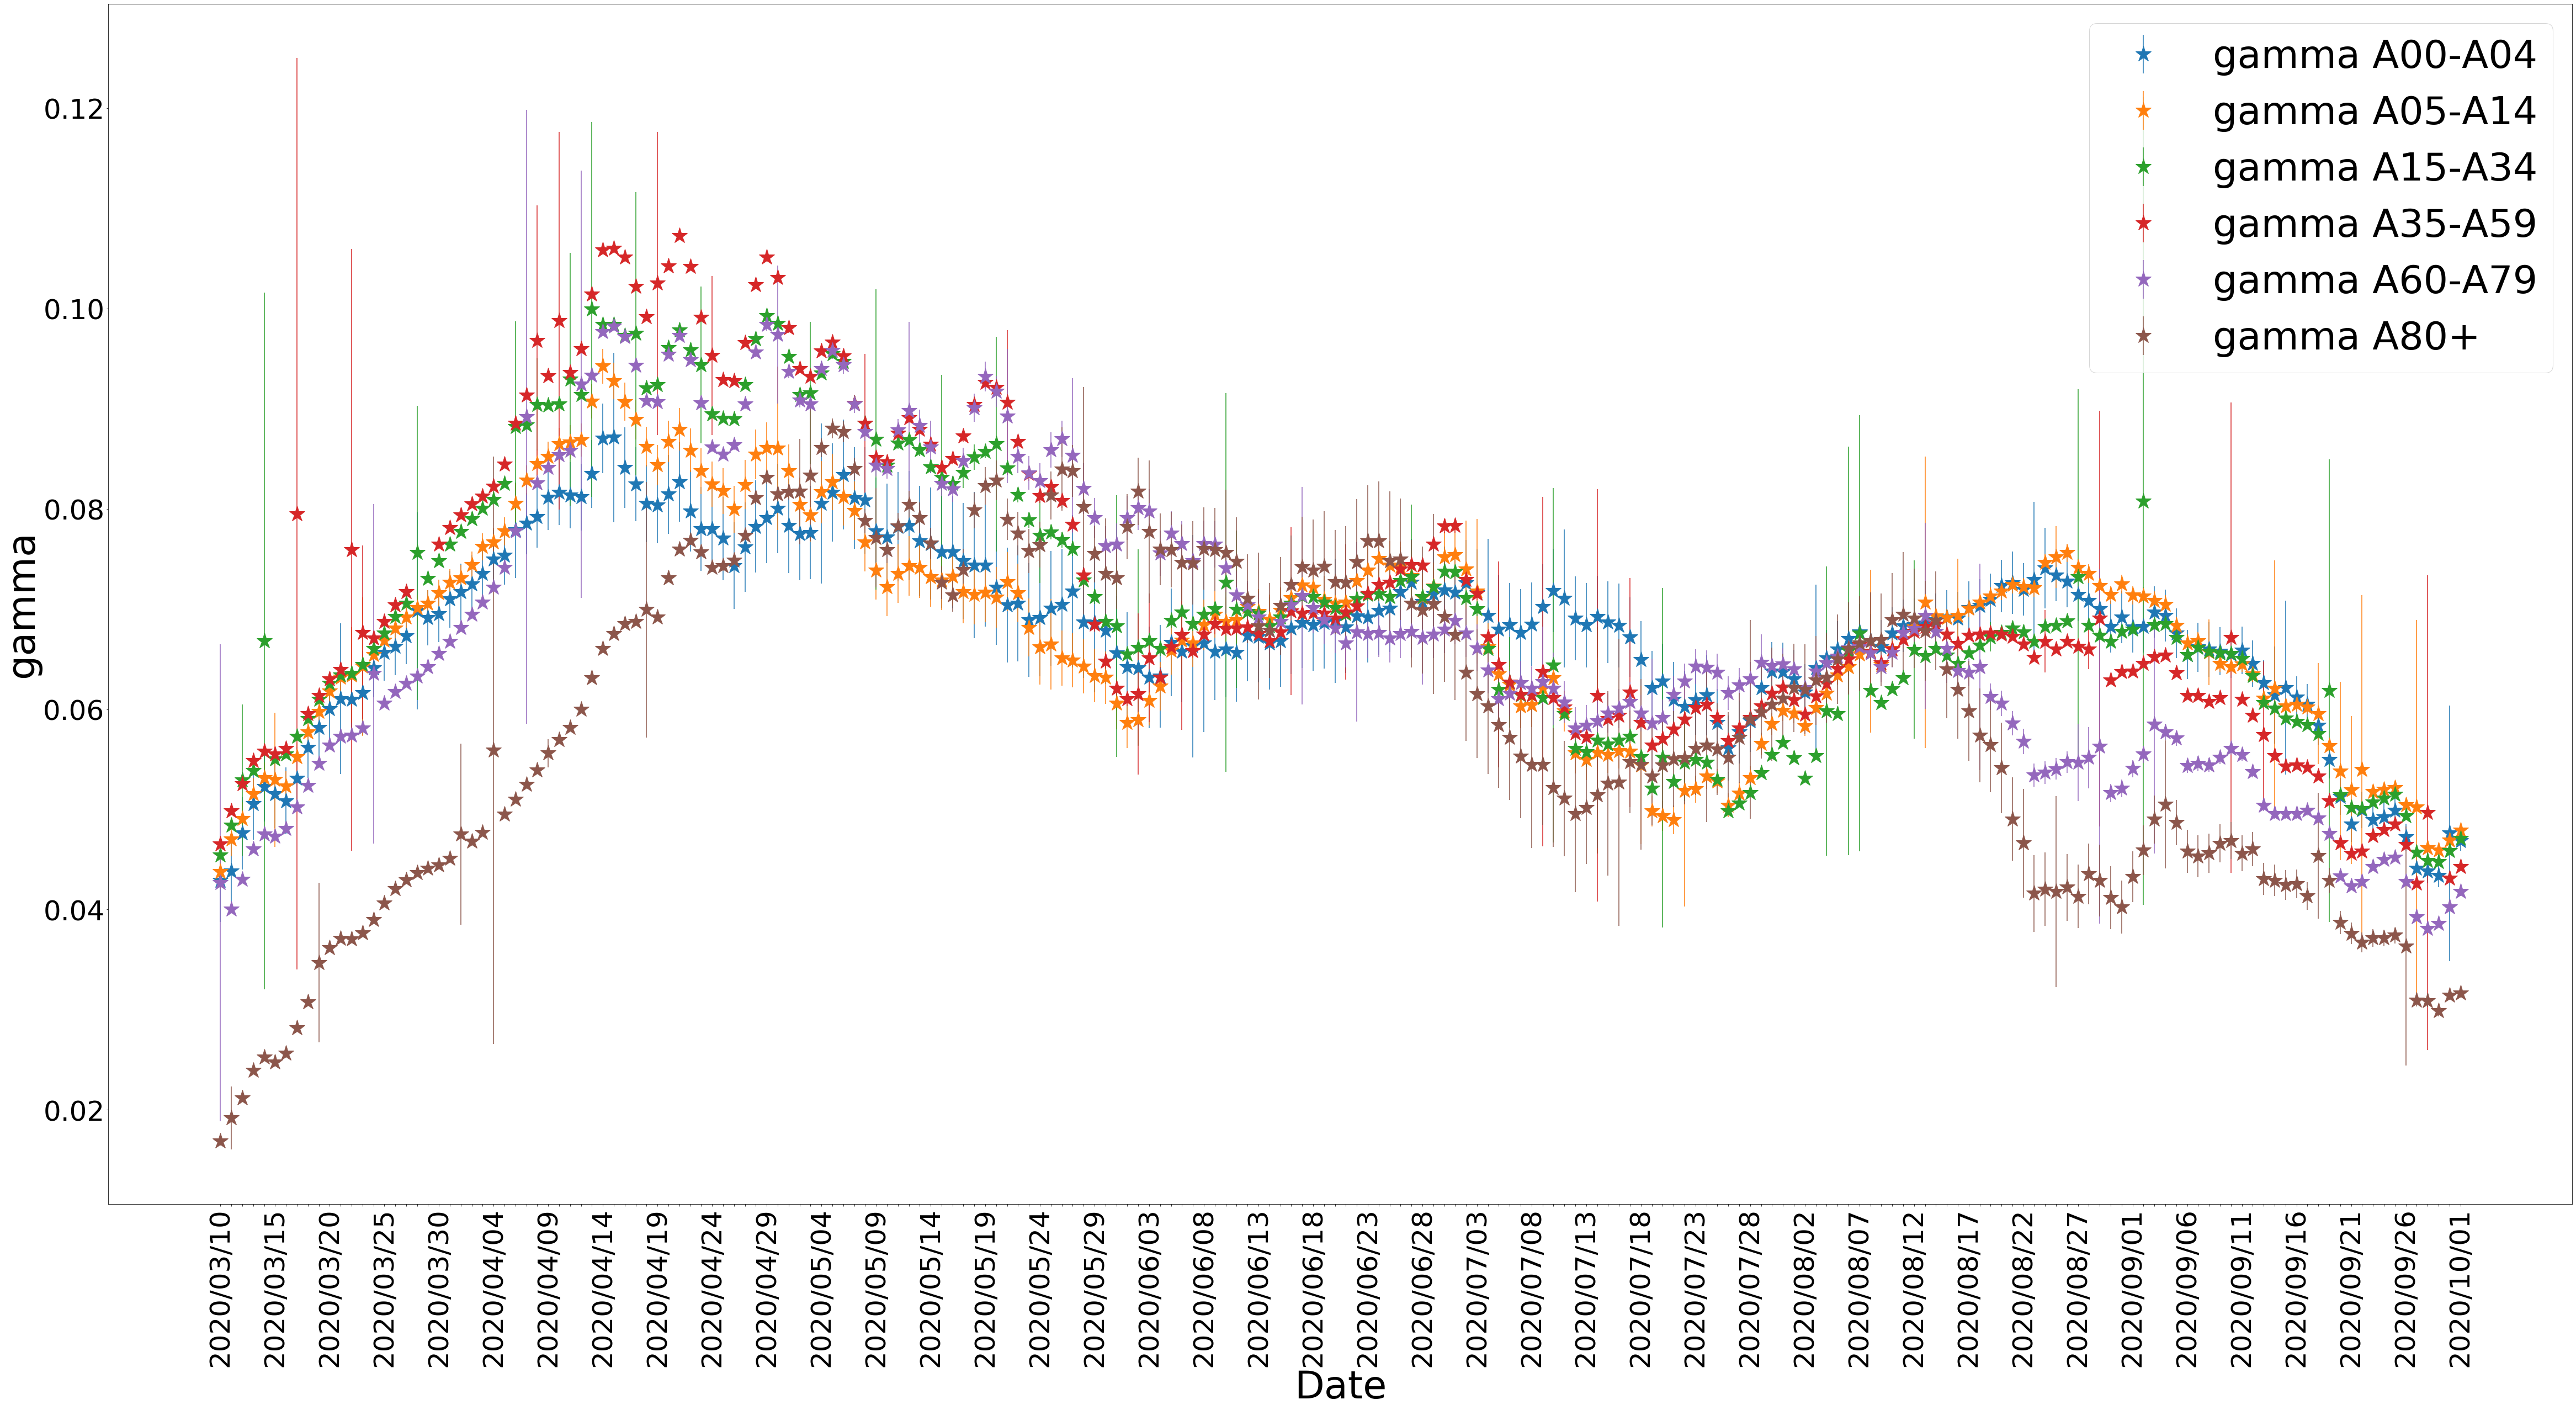

In [28]:

plt.figure(figsize=(80,40))
for i in range(len(beta_ages_method2)):
    plt.errorbar(np.array(range(len(beta_ages_method2[i]))),gamma_ages[i],gamma_ages_std[i],linestyle='None',  marker='*',markersize=30,label='gamma '+age_classes[i])

plt.xticks(np.arange(len(dates[:len(beta_all)])), dates[:len(beta_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('gamma',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

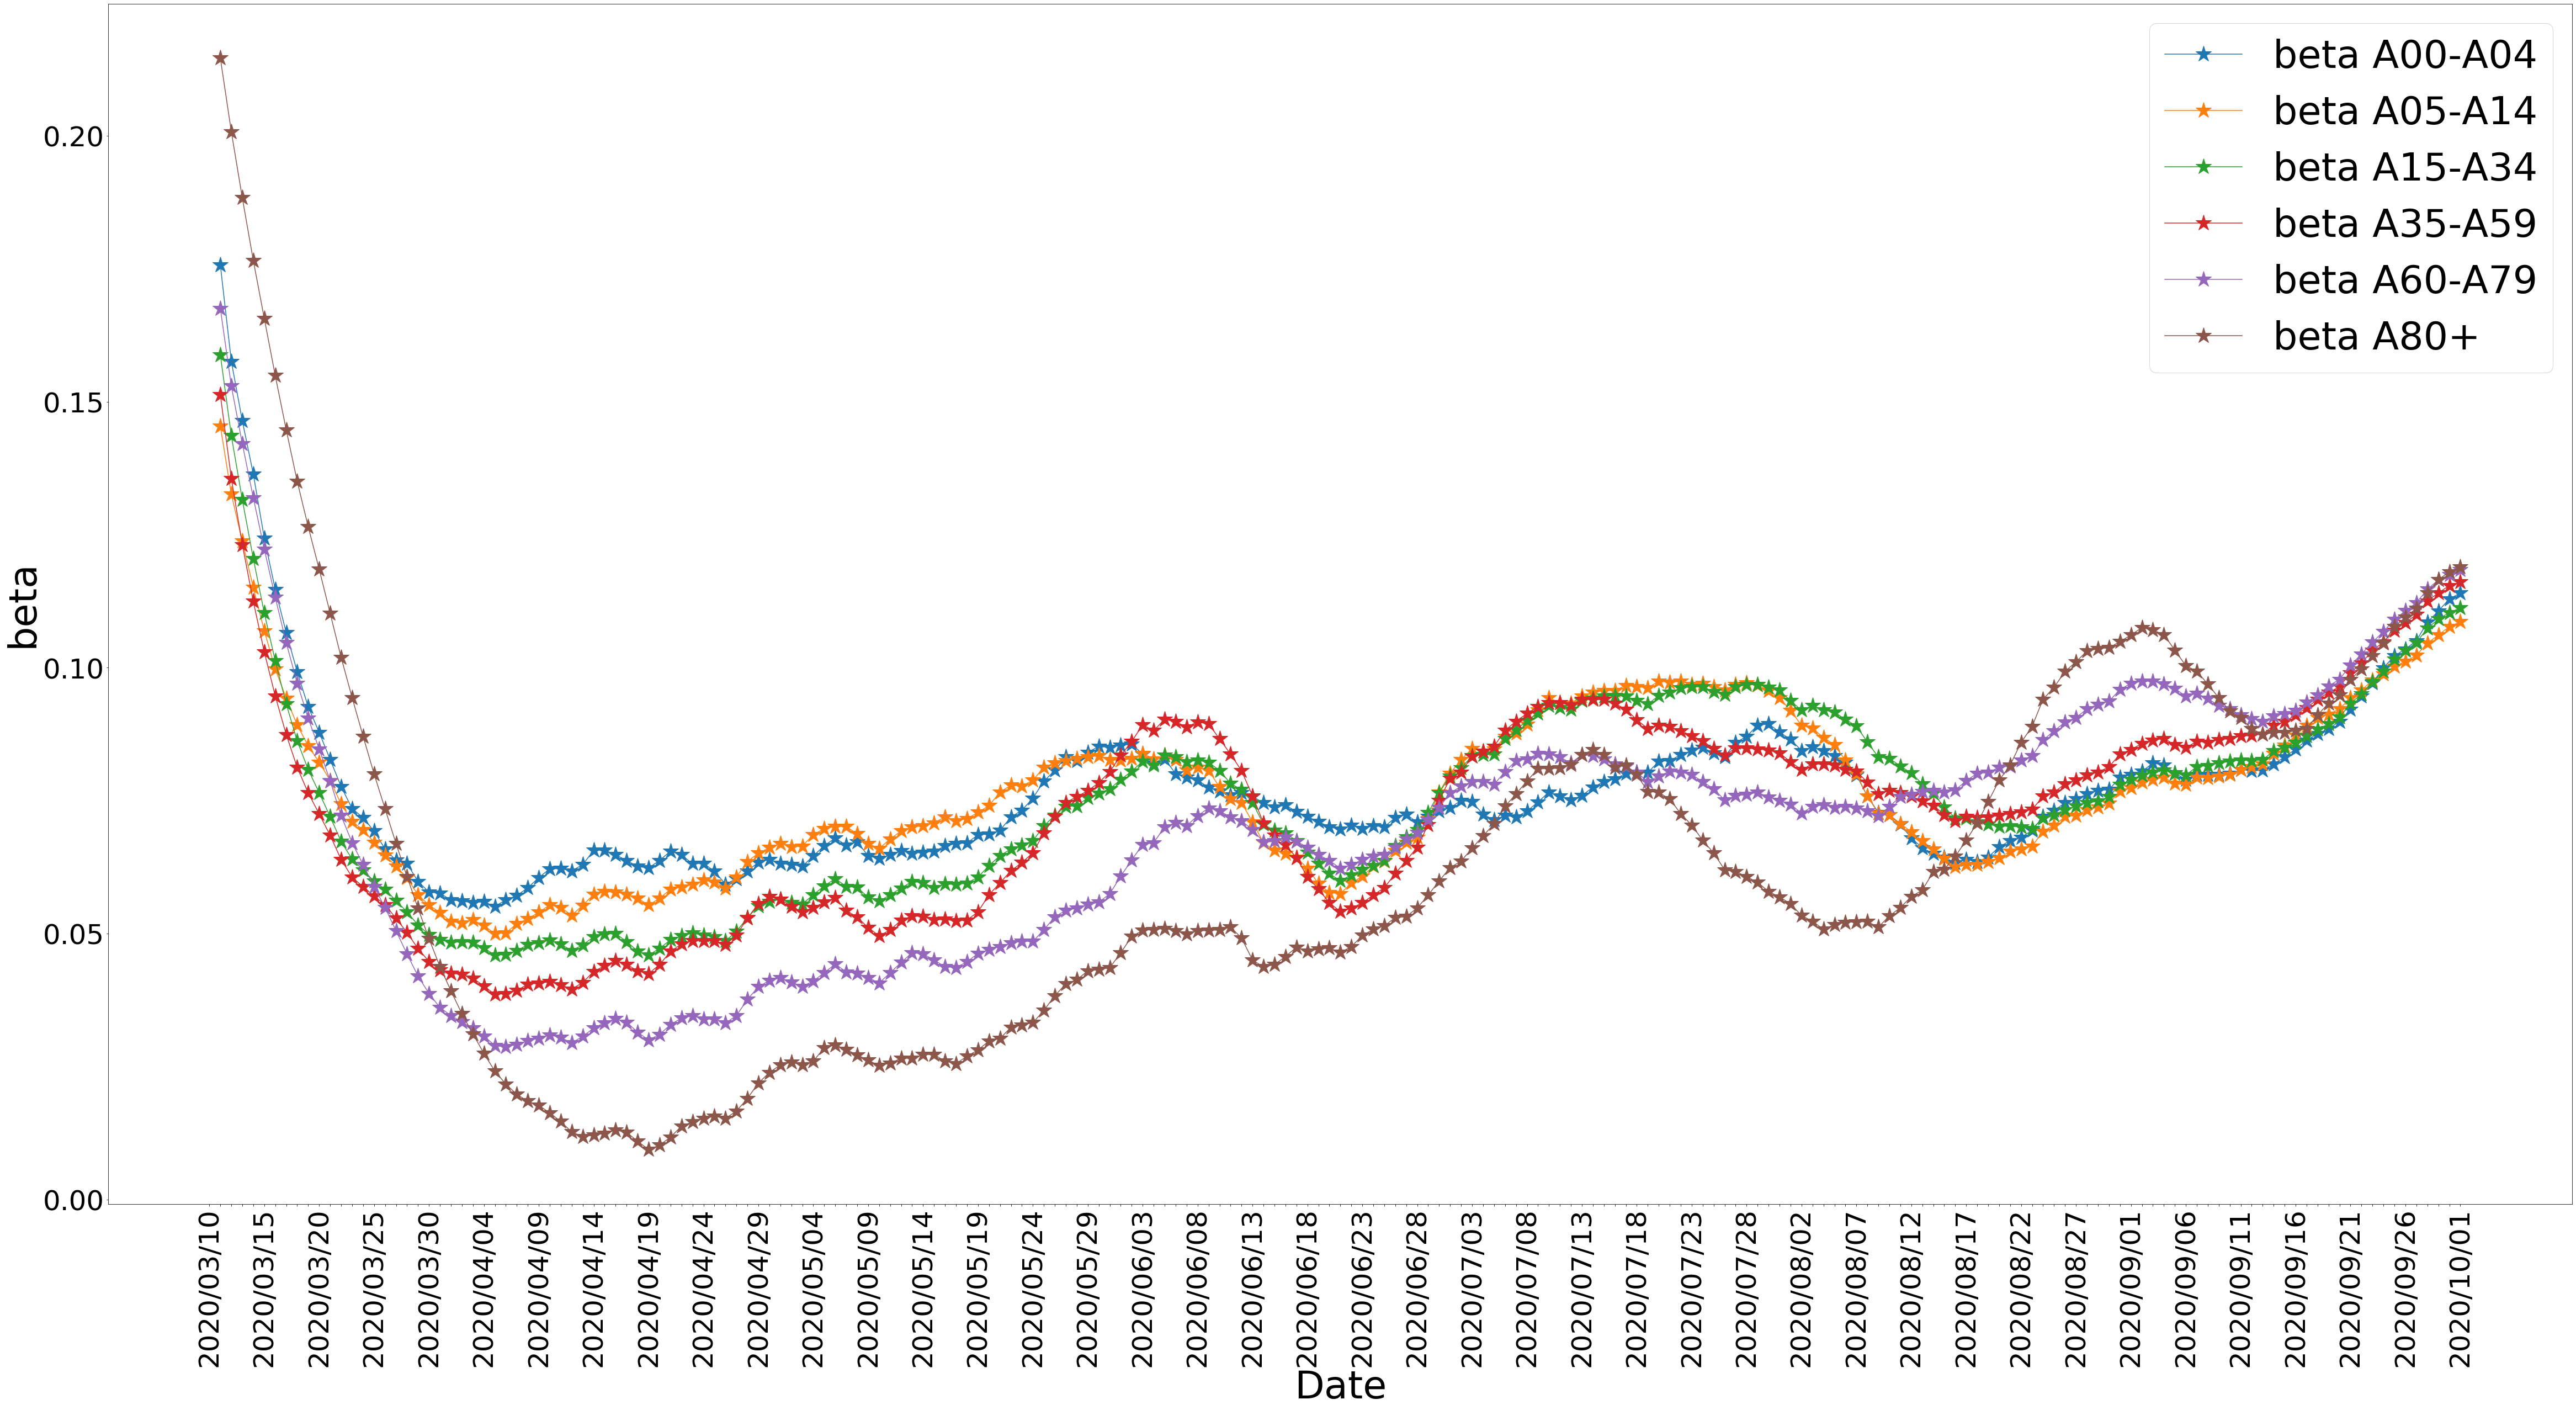

In [29]:

plt.figure(figsize=(80,40))
for i in range(len(beta_ages_method2)):
    plt.plot(np.array(range(len(beta_ages_method2[i]))),beta_ages_method2[i],  marker='*',markersize=30,label='beta '+age_classes[i])

plt.xticks(np.arange(len(dates[:len(beta_all)])), dates[:len(beta_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('beta',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

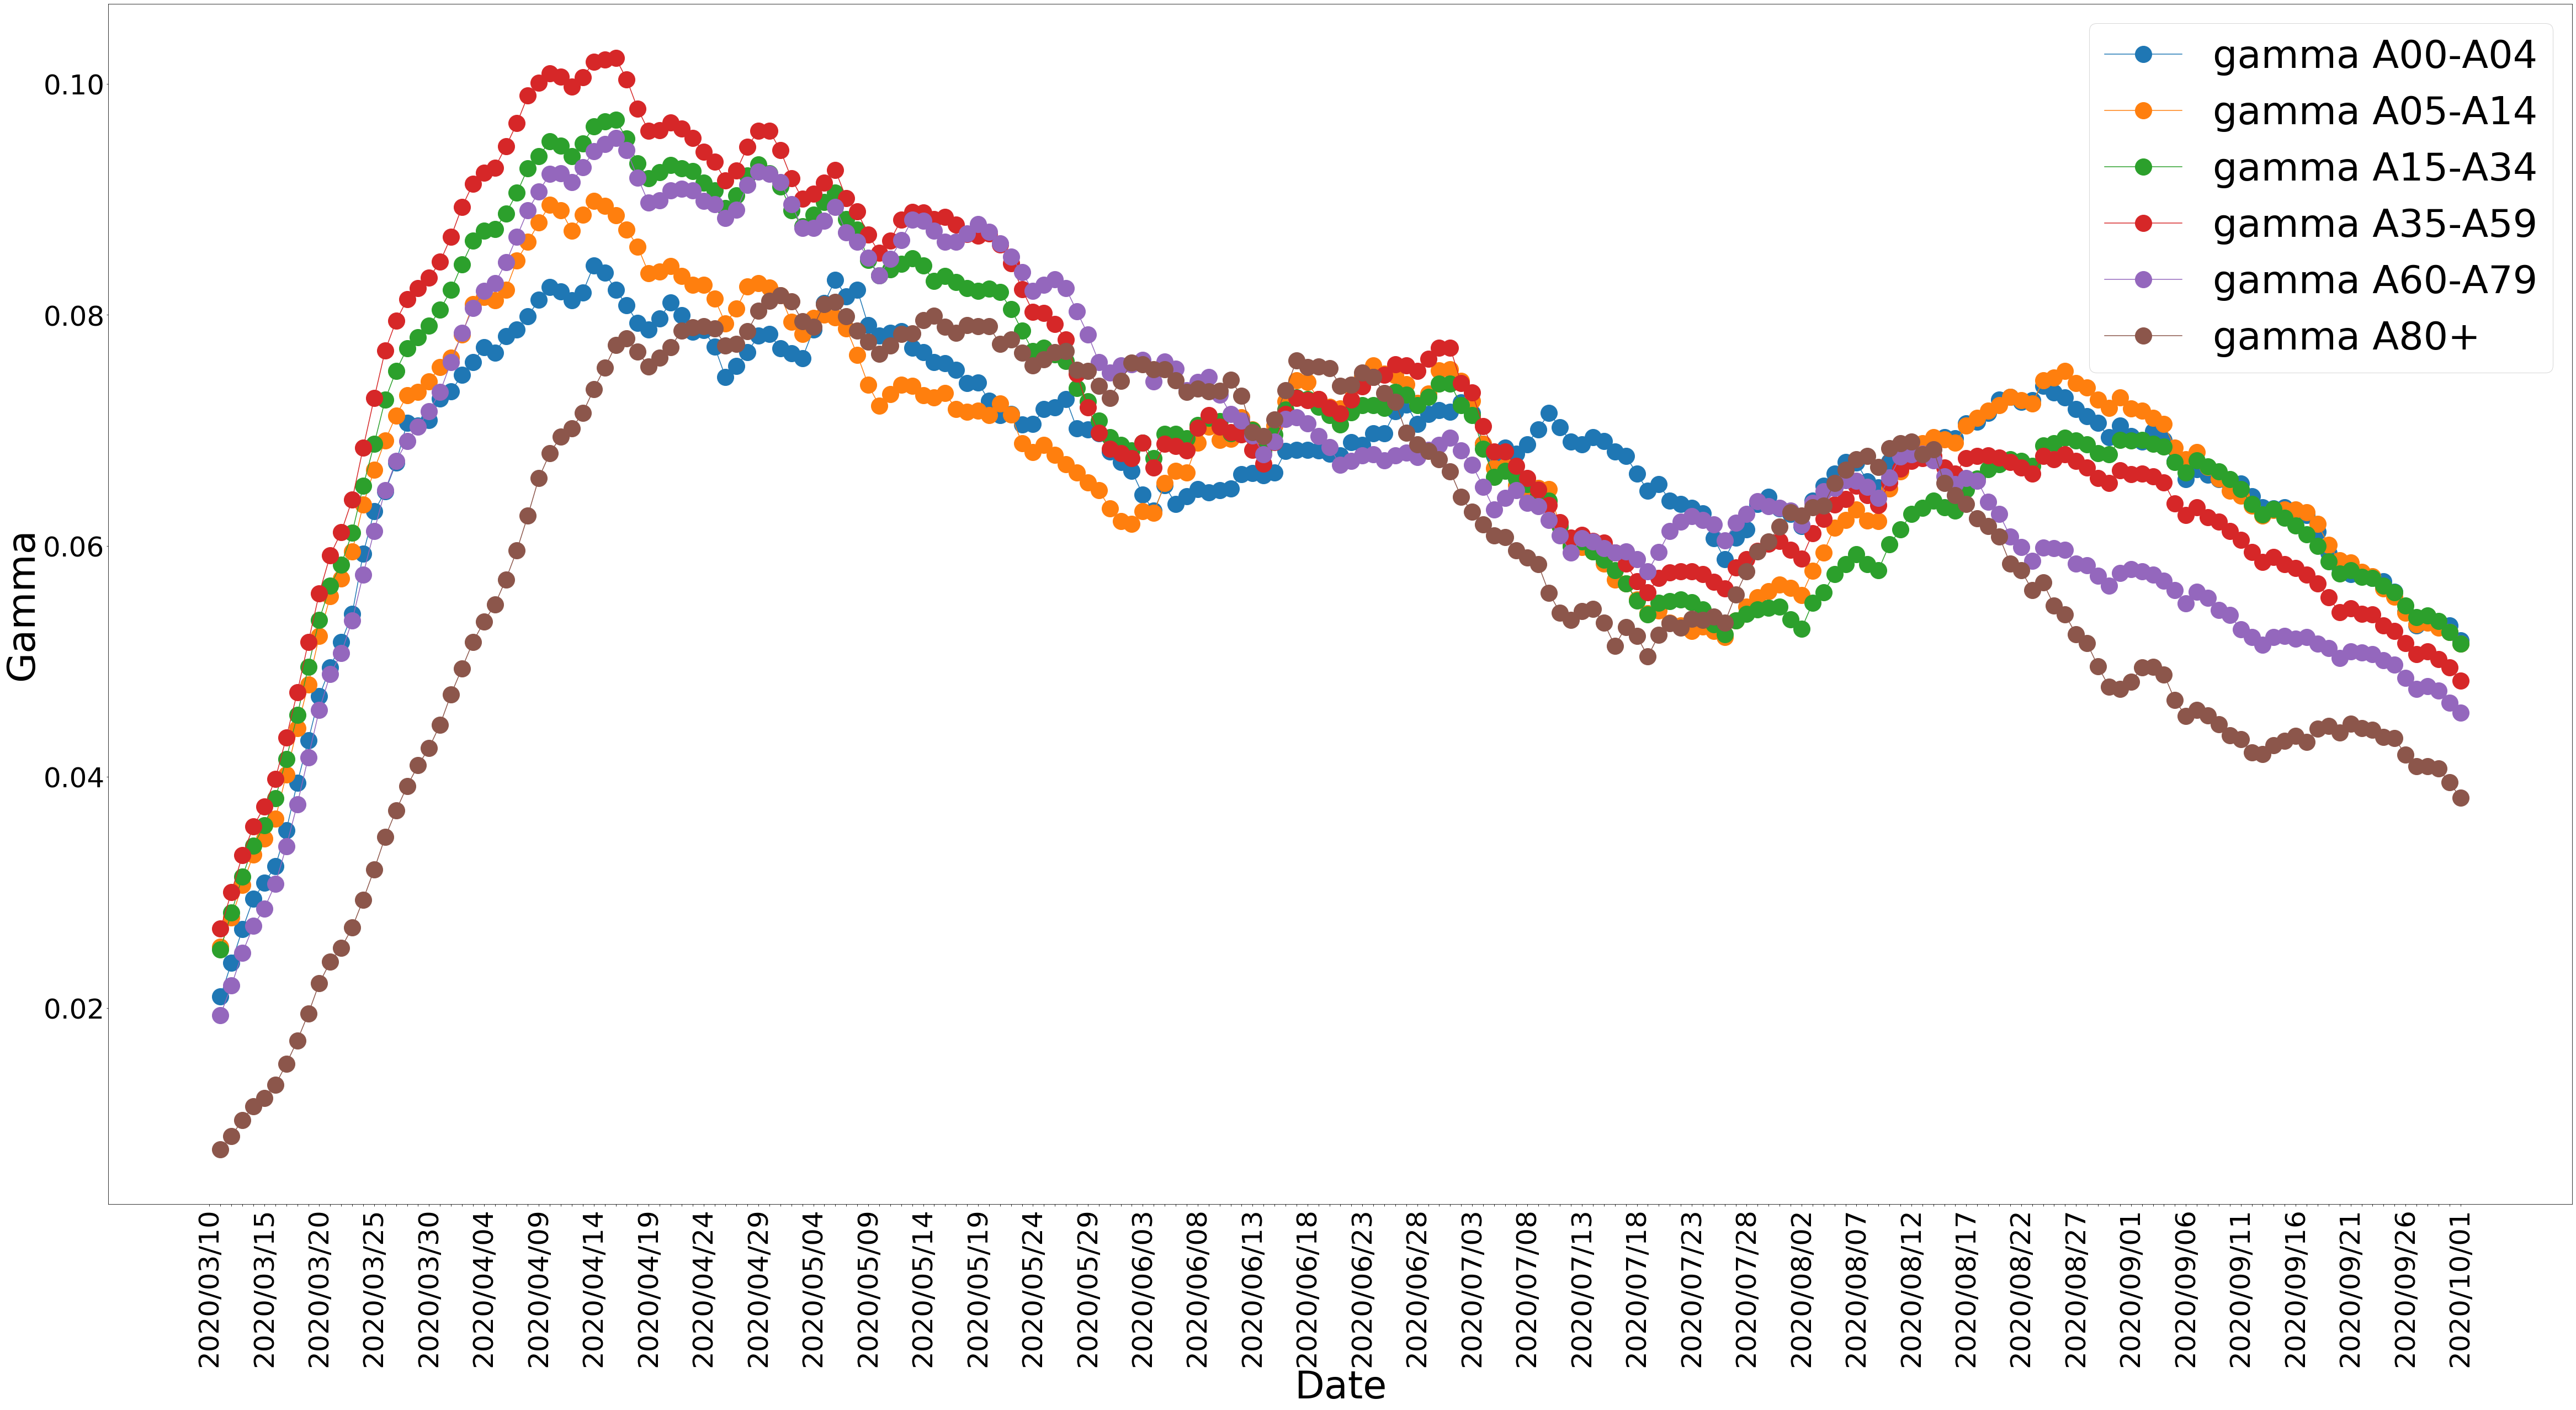

In [30]:
plt.figure(figsize=(80,40))
for i in range(len(gamma_ages_method2)):
    plt.plot(np.array(range(len(gamma_ages_method2[i]))),gamma_ages_method2[i],  marker='o',markersize=30,label='gamma '+age_classes[i])

plt.xticks(np.arange(len(dates[:len(beta_all)])), dates[:len(beta_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('Gamma',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

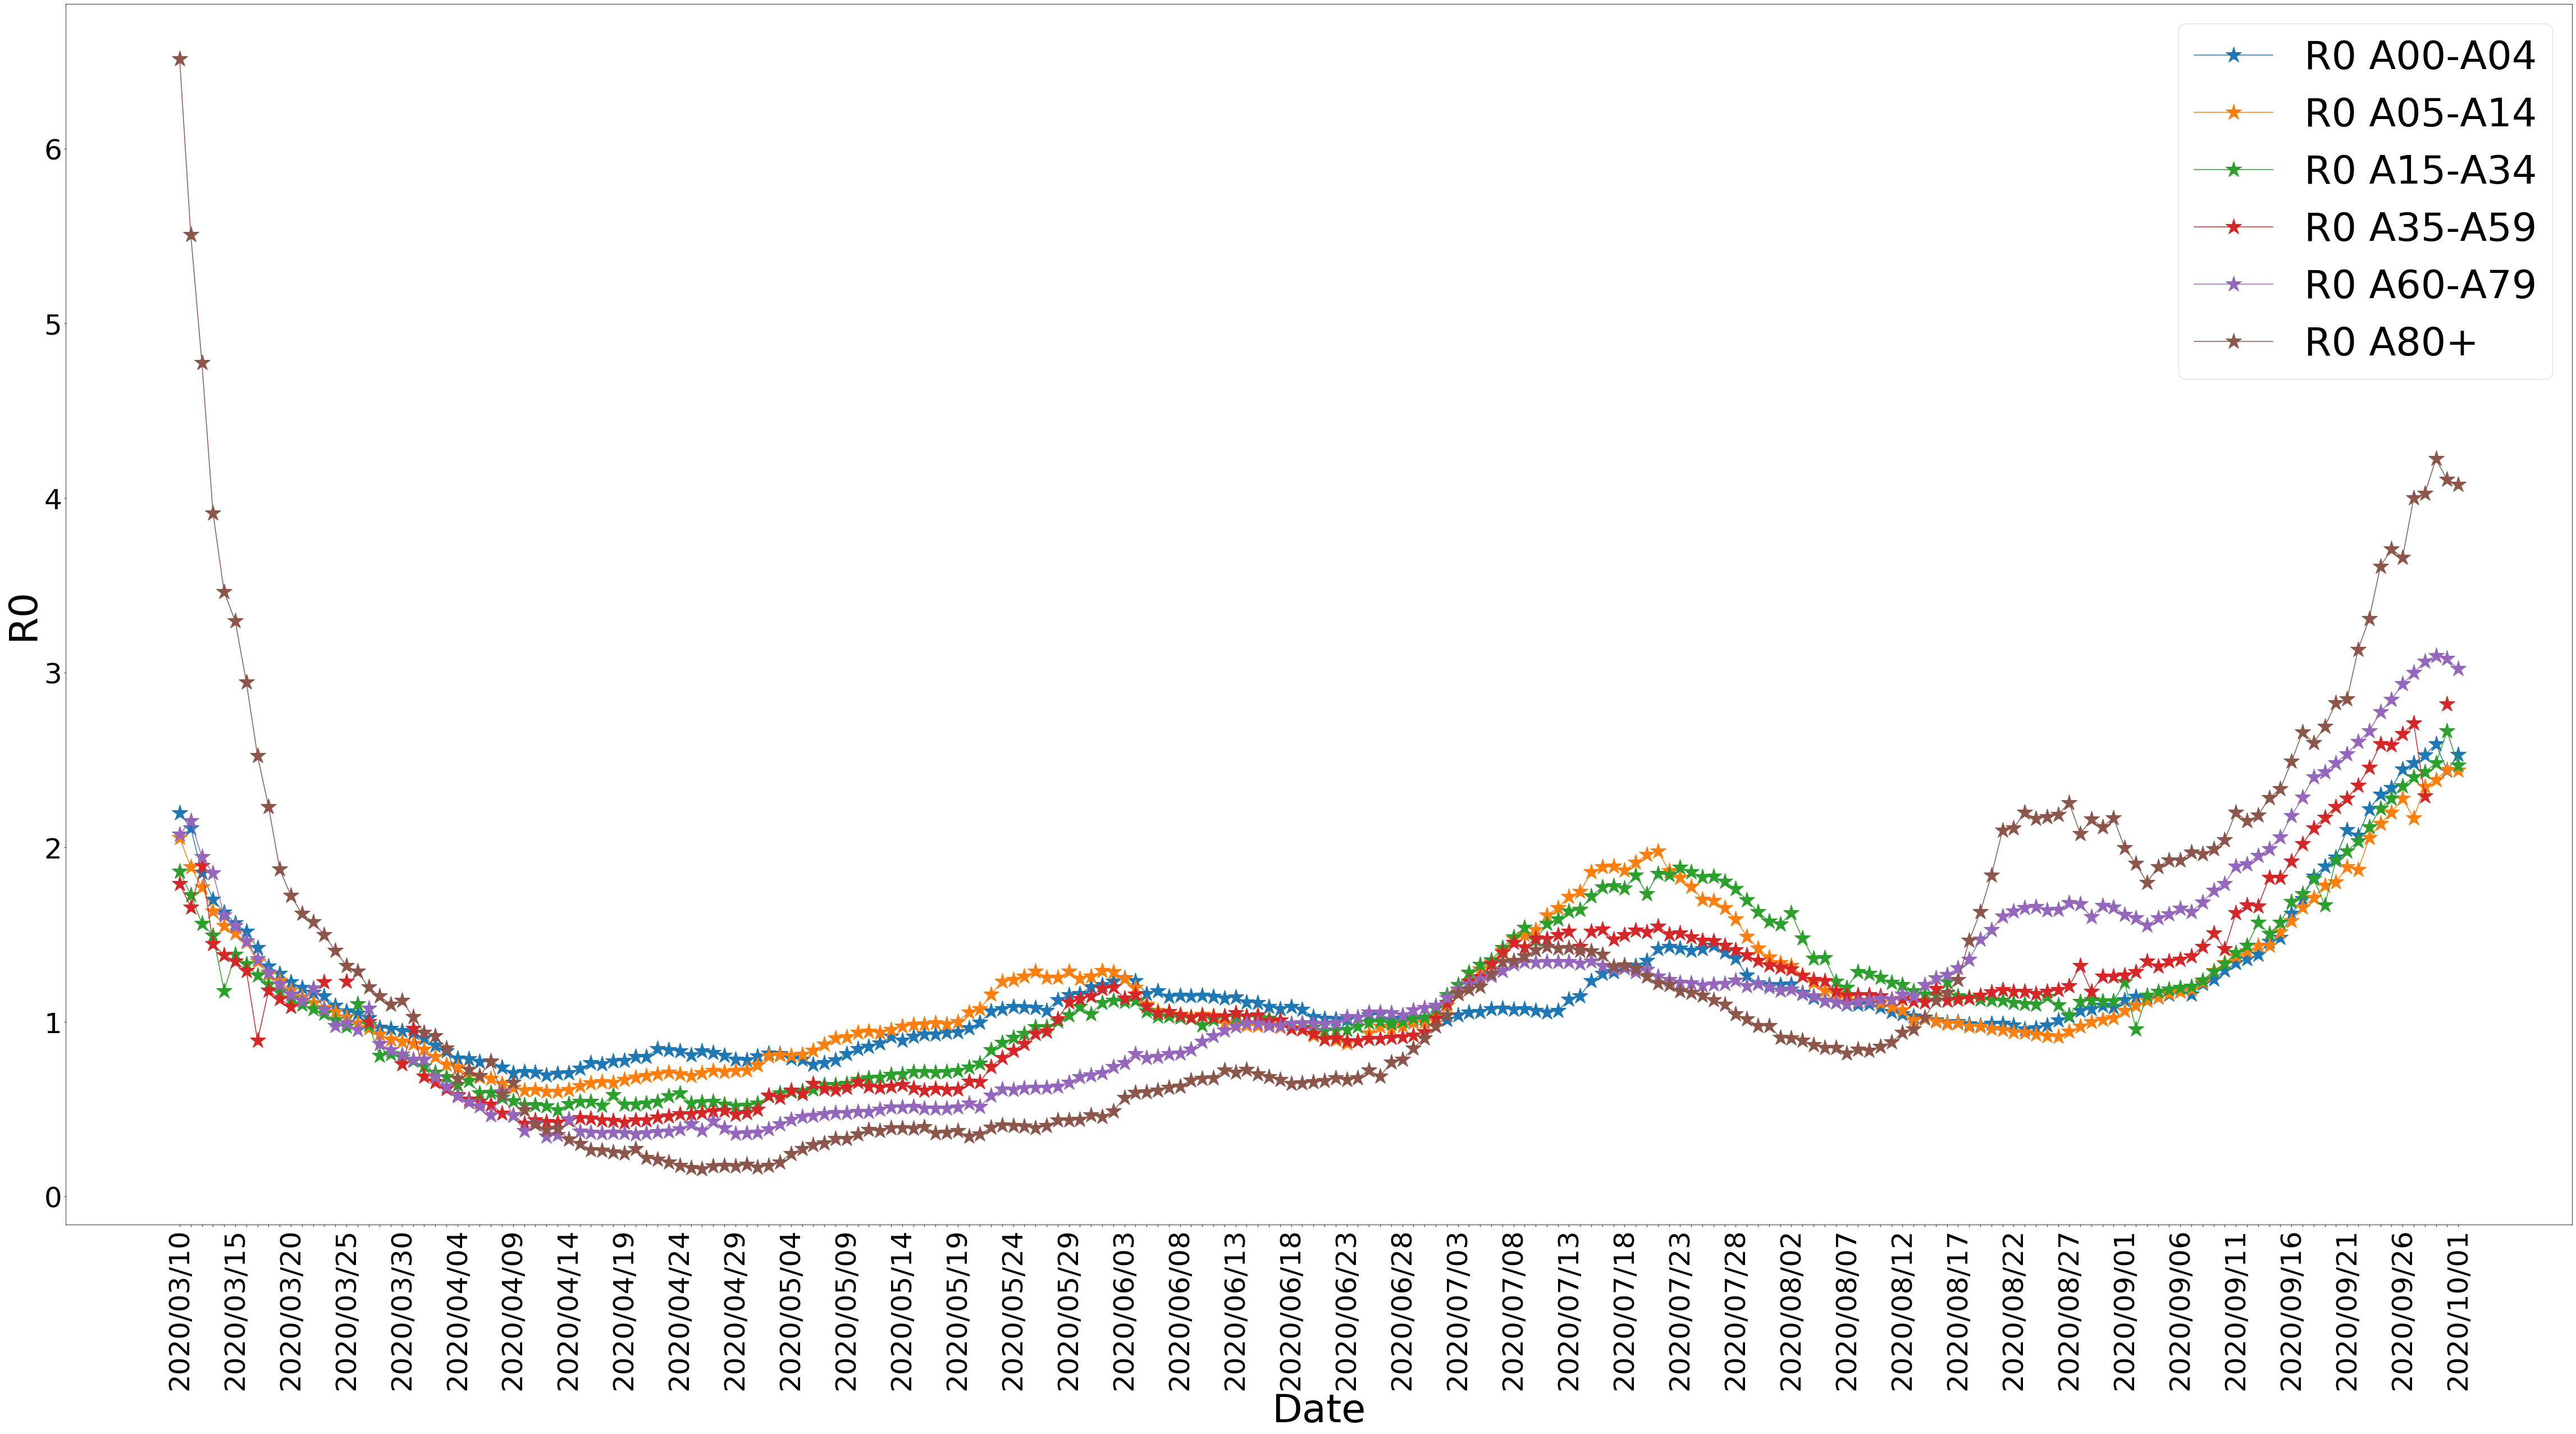

In [31]:
plt.figure(figsize=(80,40))
for i in range(len(beta_ages_method2)):
    plt.plot(np.array(range(len(beta_ages_method2[i]))),R0_ages[i],  marker='*',markersize=30,label='R0 '+age_classes[i])

plt.xticks(np.arange(len(dates[:len(beta_all)])), dates[:len(beta_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('R0',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

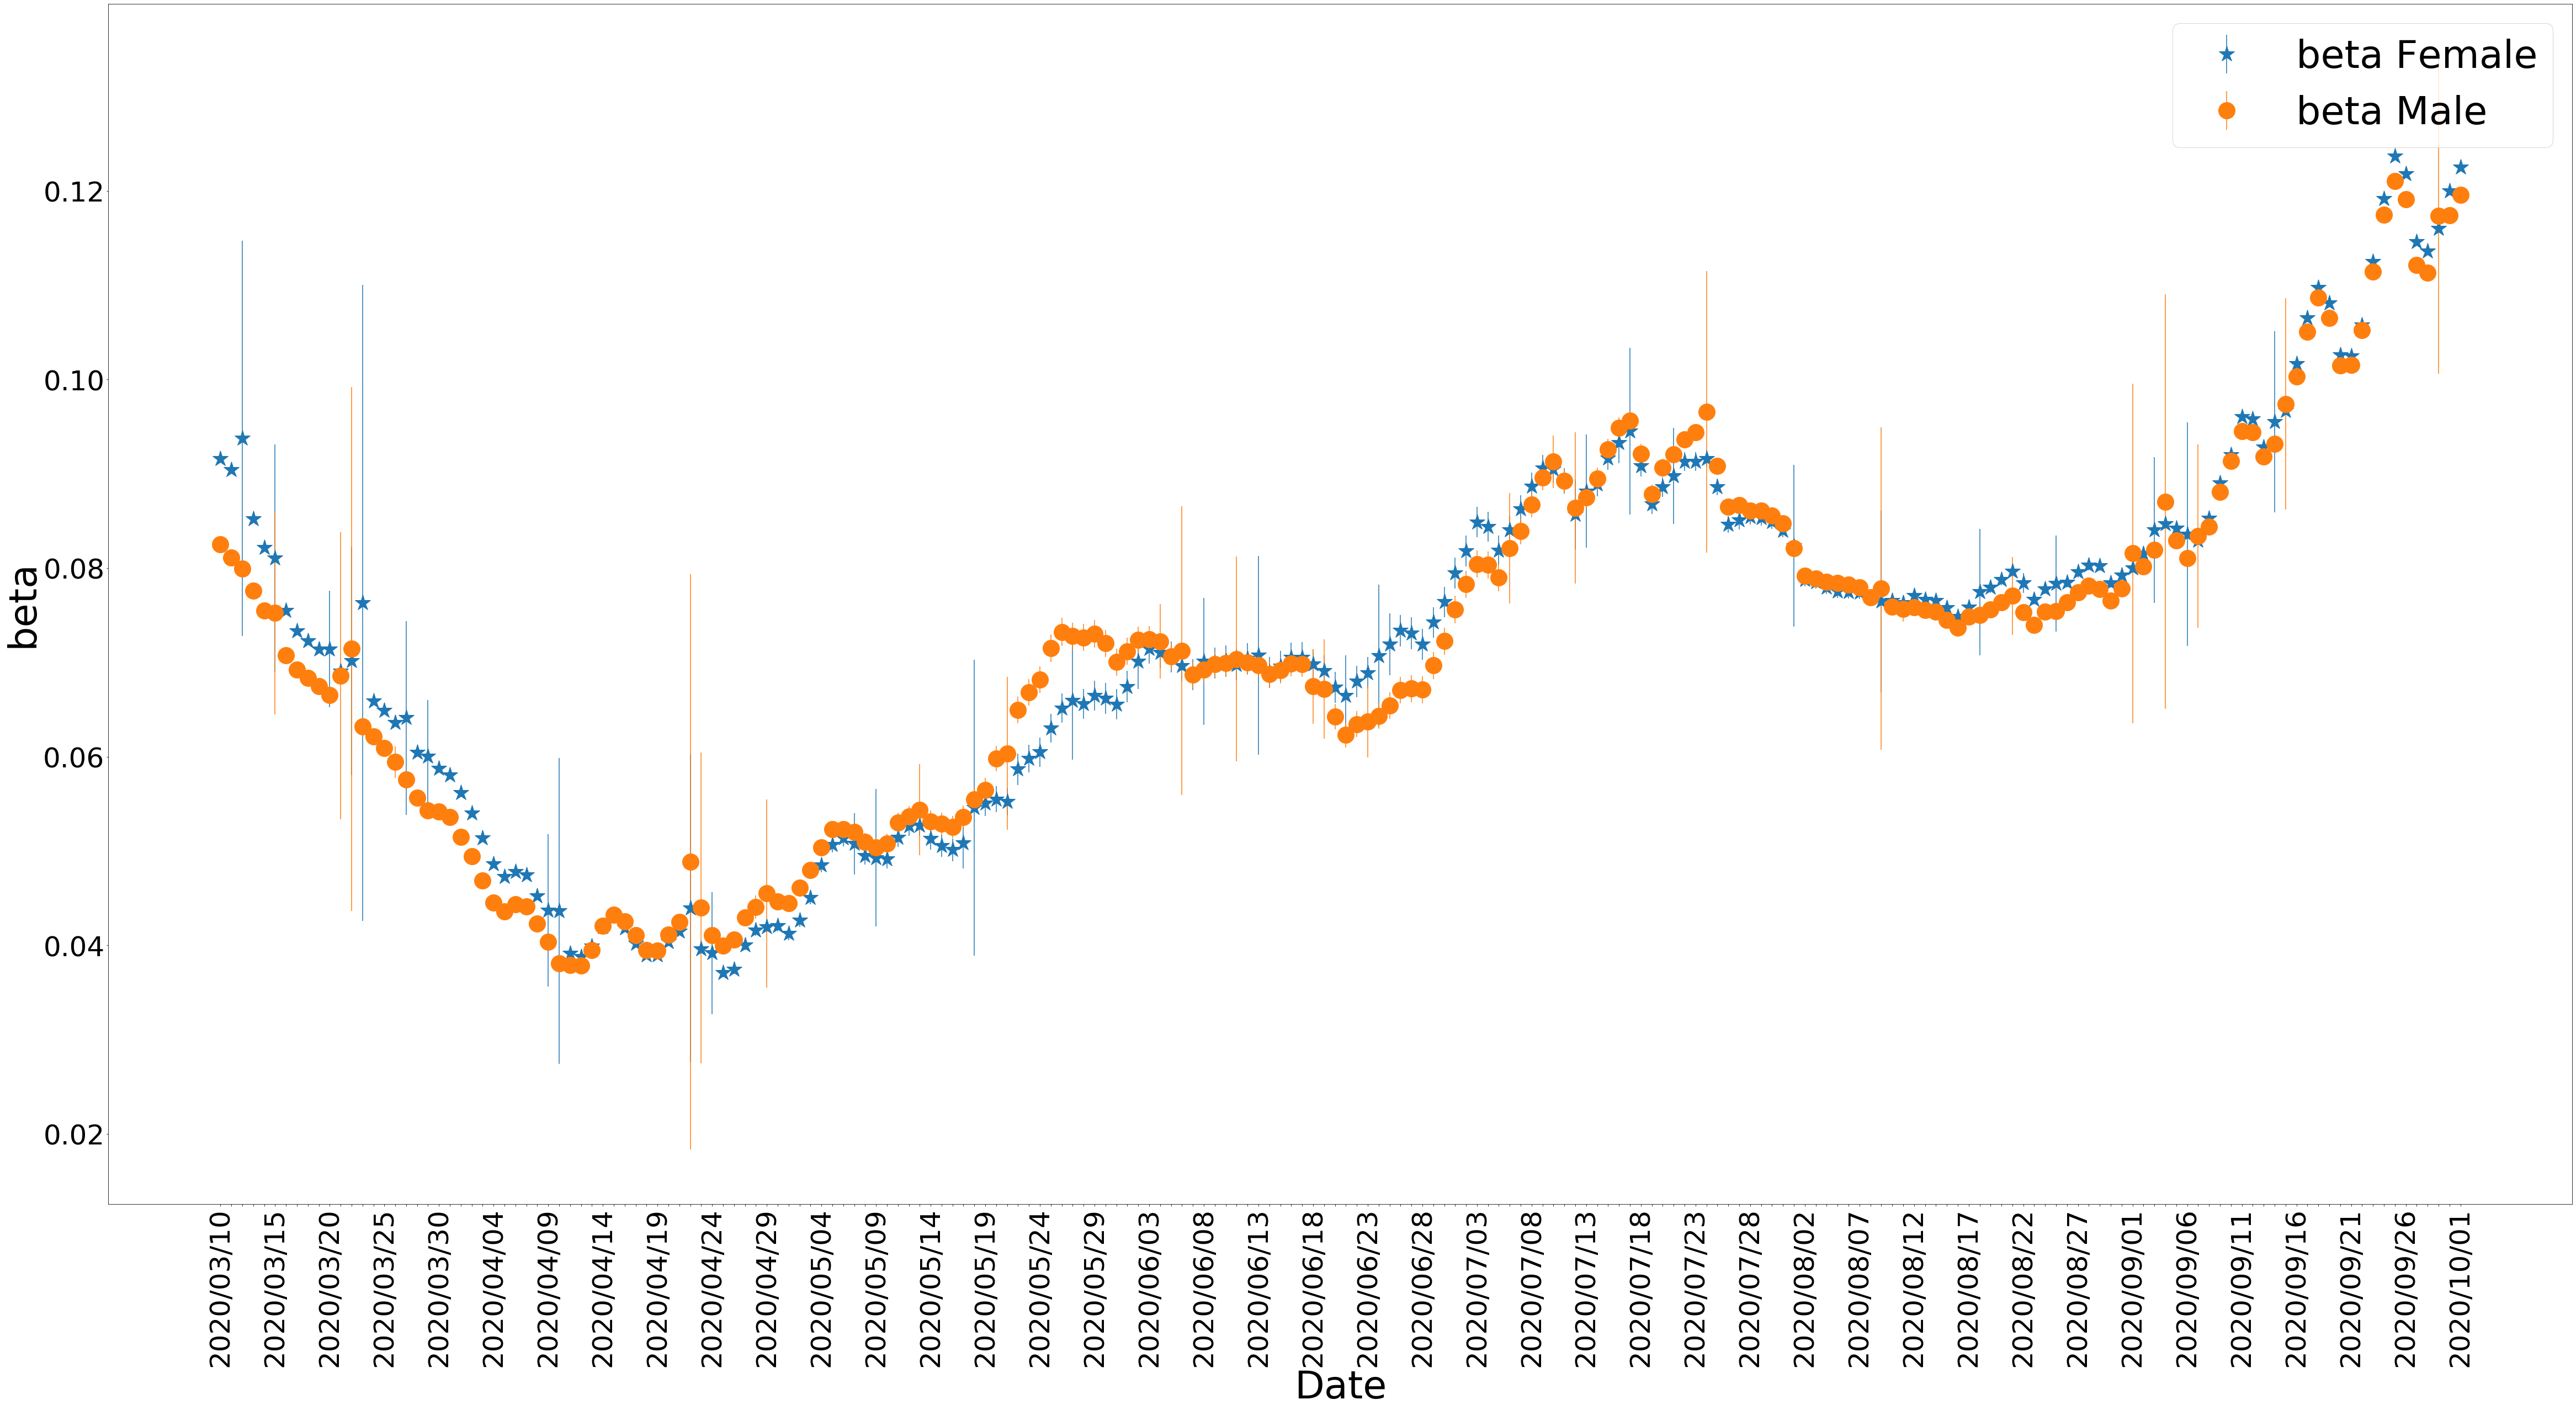

In [32]:
plt.figure(figsize=(80,40))
plt.errorbar(np.array(range(len(beta_sex[0]))),beta_sex[0], beta_sex_std[0], linestyle='None', marker='*',markersize=30,label='beta Female')
plt.errorbar(np.array(range(len(beta_sex[1]))),beta_sex[1], beta_sex_std[1], linestyle='None', marker='o',markersize=30,label='beta Male')
plt.xticks(np.arange(len(dates[:len(beta_all)])), dates[:len(beta_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('beta',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

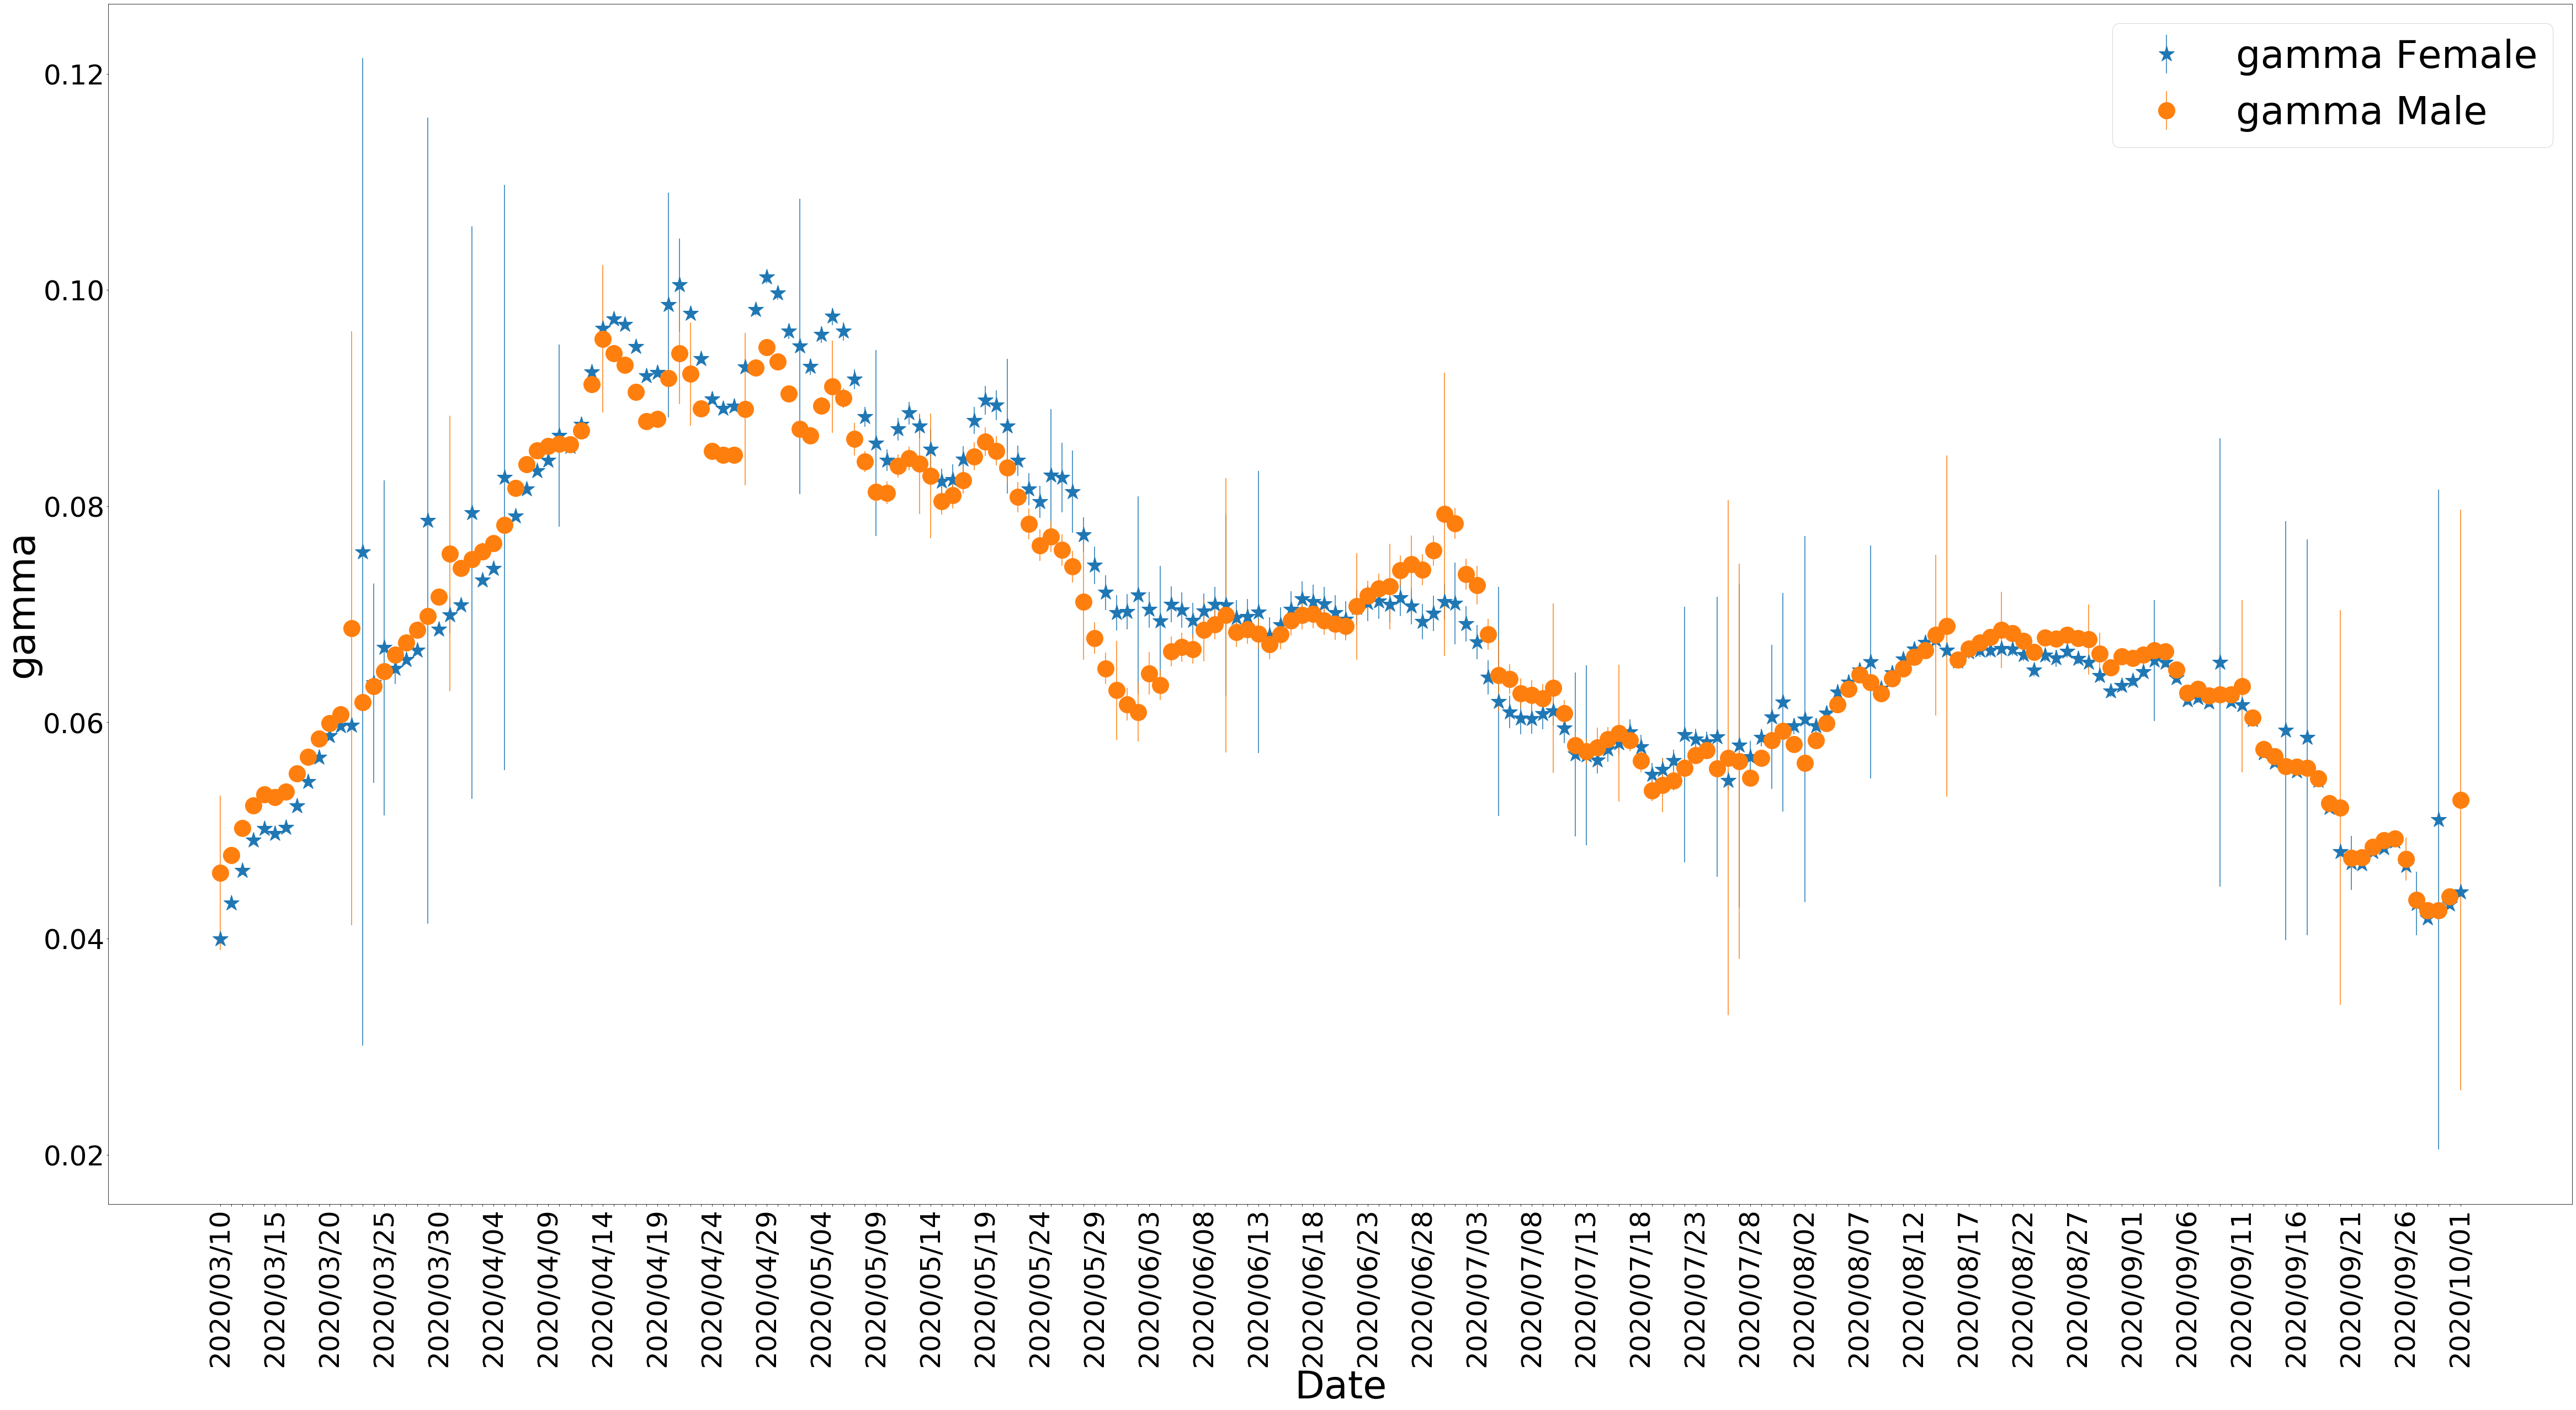

In [33]:
plt.figure(figsize=(80,40))
plt.errorbar(np.array(range(len(gamma_sex[0]))),gamma_sex[0], gamma_sex_std[0], linestyle='None', marker='*',markersize=30,label='gamma Female')
plt.errorbar(np.array(range(len(gamma_sex[1]))),gamma_sex[1], gamma_sex_std[1], linestyle='None', marker='o',markersize=30,label='gamma Male')
plt.xticks(np.arange(len(dates[:len(gamma_all)])), dates[:len(gamma_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('gamma',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)

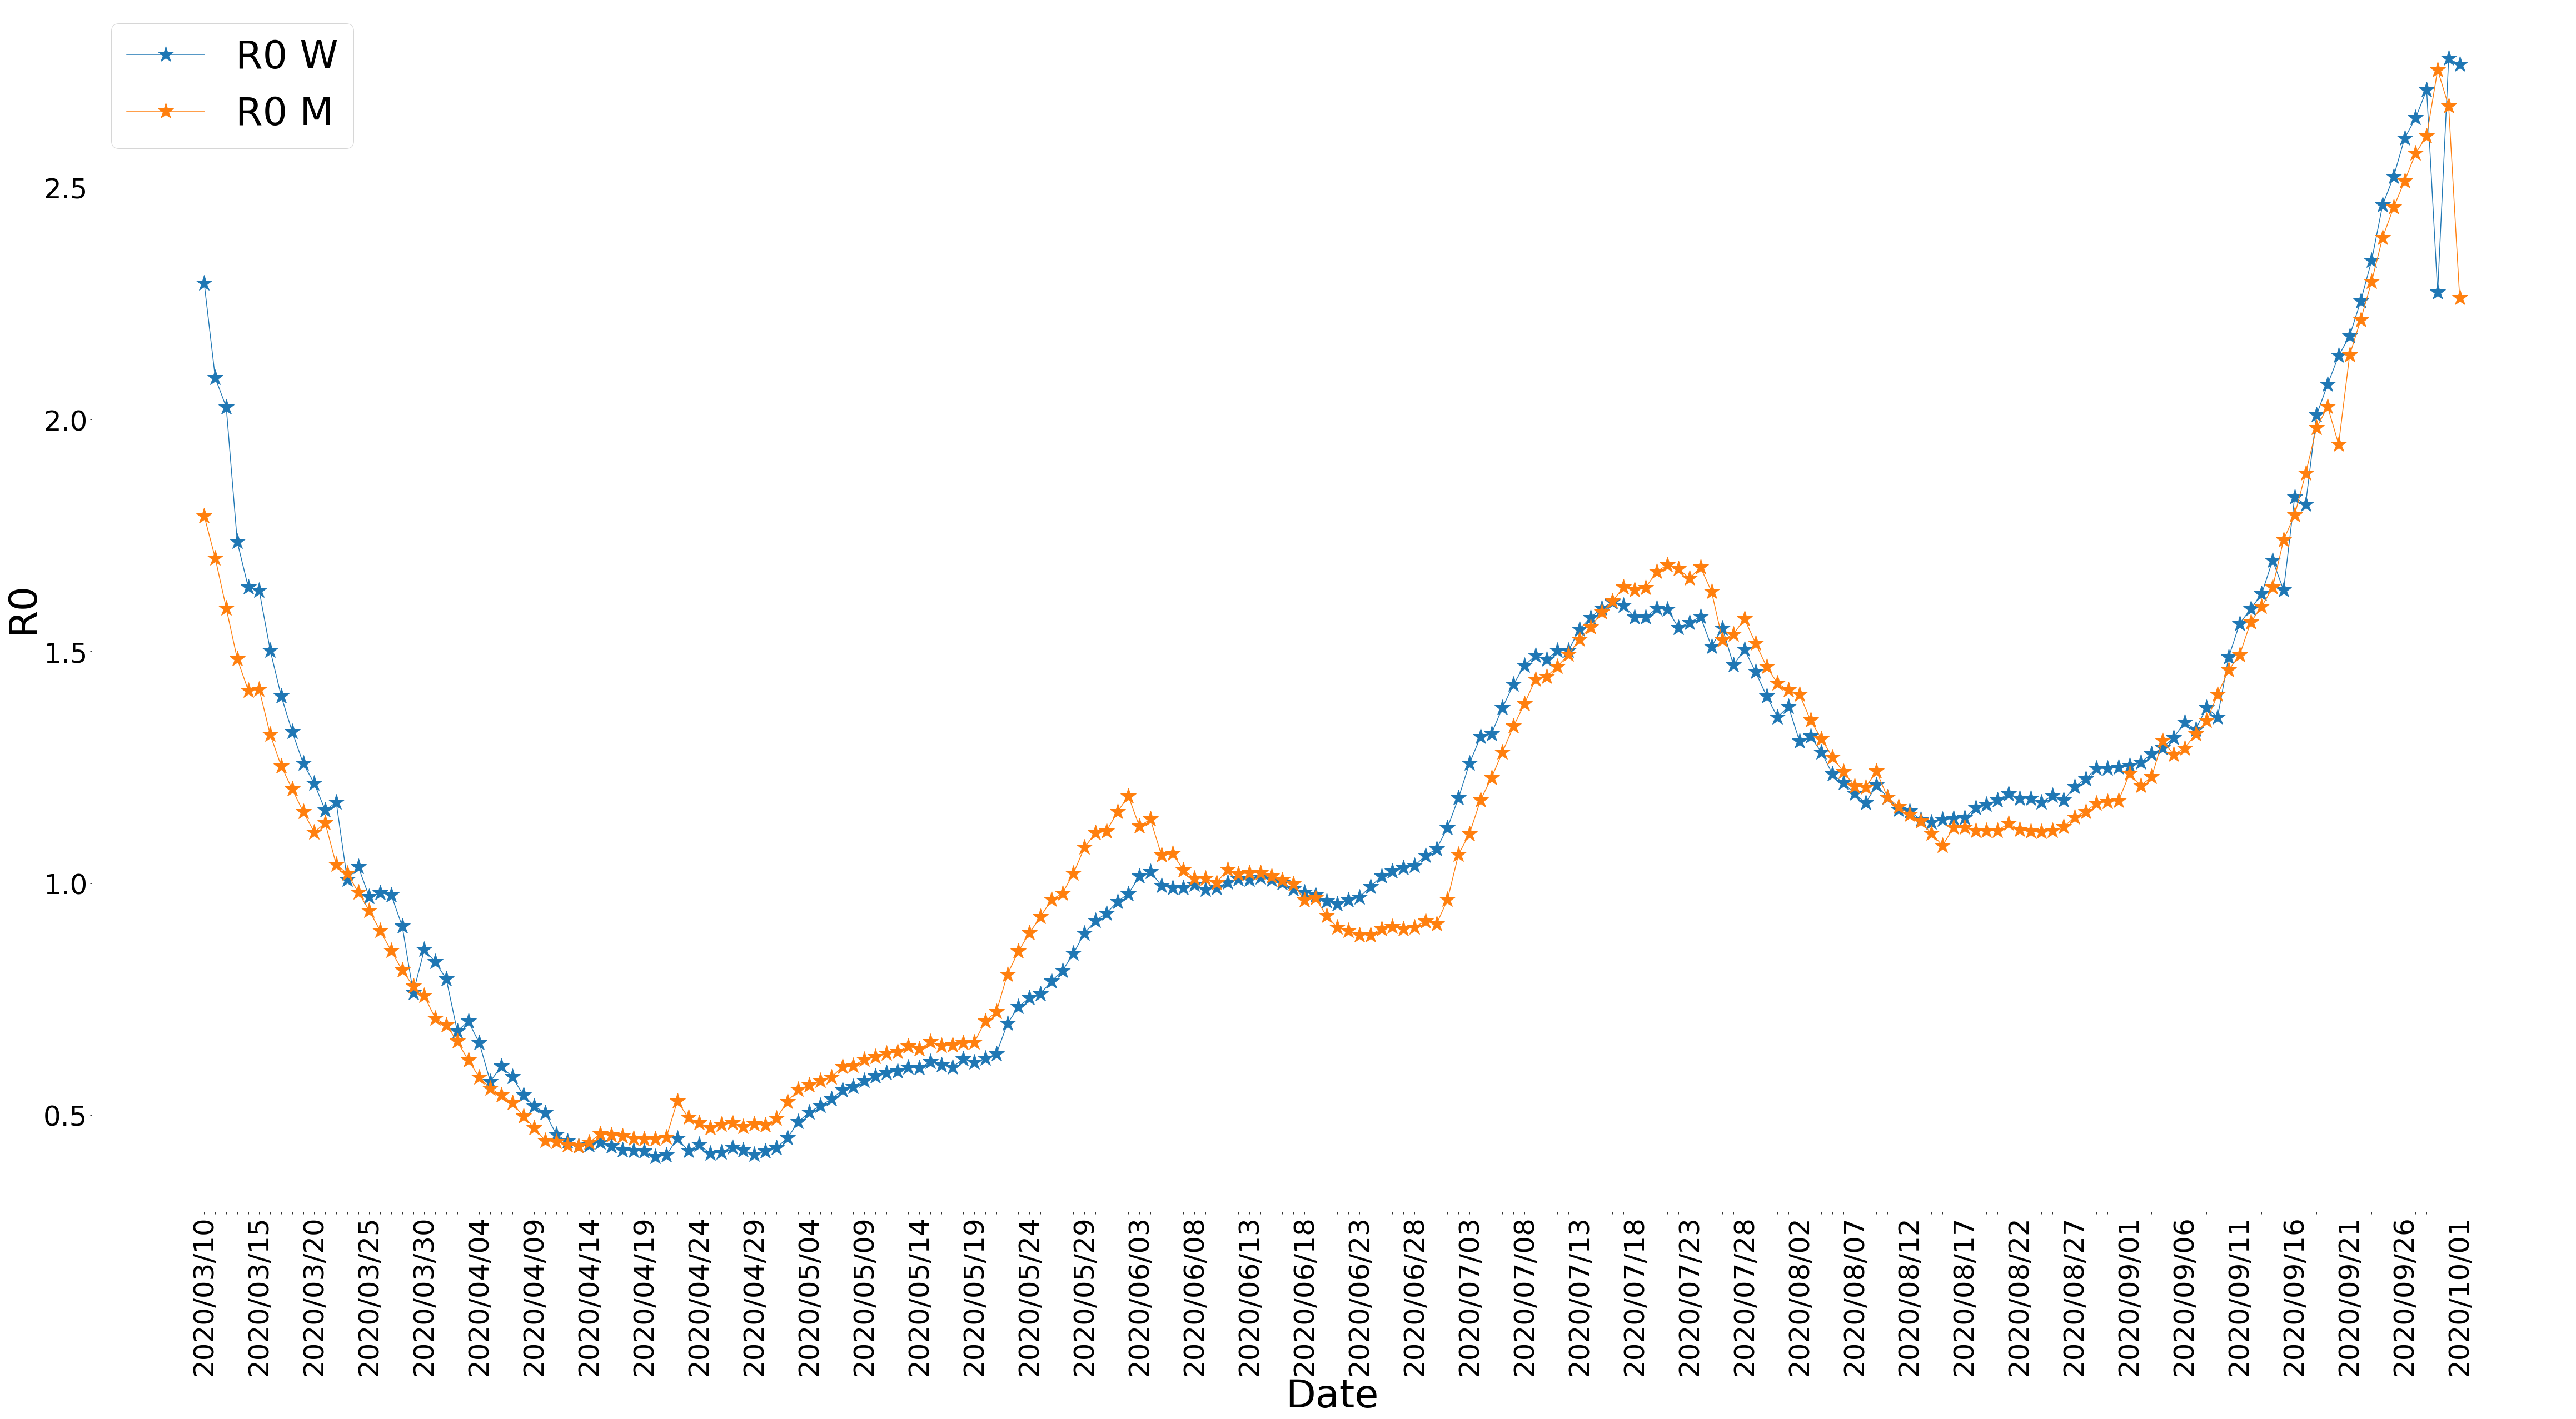

In [34]:
plt.figure(figsize=(80,40))
for i in range(len(beta_sex)):
    plt.plot(np.array(range(len(beta_ages_method2[i]))),R0_sex[i],  marker='*',markersize=30,label='R0 '+sex_classes[i])

plt.xticks(np.arange(len(dates[:len(beta_all)])), dates[:len(beta_all)],rotation=90,fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('R0',fontsize=70)
plt.xlabel('Date',fontsize=70)
plt.legend(loc=0,fontsize=70)